<a href="https://colab.research.google.com/github/shobrunjb/MahasiswaLancer/blob/main/draft-04-multitask-multilabel.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Library


In [2]:

!pip install Sastrawi
!pip install swifter
!pip install emoji
import pandas as pd
import numpy as np
import re
import emoji
import string
import seaborn as sns
import matplotlib.pyplot as plt
import swifter
from sklearn.utils import resample
from nltk.tokenize import word_tokenize
from nltk.probability import FreqDist
from nltk.corpus import stopwords
from Sastrawi.Stemmer.StemmerFactory import StemmerFactory
from collections import Counter
from wordcloud import WordCloud
from tqdm import tqdm

# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

# You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All"
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 209.7/209.7 kB 3.7 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.2/1.2 MB 22.7 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
  Created wheel for swifter: filename=swifter-1.4.0-py3-none-any.whl size=16507 sha256=d3c1cc9f3a1e5417028b2ed31103a2588da3cc036350c1989e996728f49f3a06
  Stored in directory: /root/.cache/pip/wheels/e4/cf/51/0904952972ee2c7aa3709437065278dc534ec1b8d2ad41b443
Successfully built swifter
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 431.4/431.4 kB 8.5 MB/s eta 0:00:00


In [3]:
# Loading Essential libraries
import warnings
warnings.filterwarnings('ignore')
%config InlineBackend.figure_format = 'retina'
%config Completer.use_jedi = False # this to force autocompletion

# Dataset

In [81]:
# df = pd.read_csv('https://raw.githubusercontent.com/Fake-Review-Detection-Spiill-AI/screnario-2---multi-task/main/draft02_dataset_review_pribadi.csv',) #draft 02
df = pd.read_csv('https://raw.githubusercontent.com/Fake-Review-Detection-Spiill-AI/screnario-2---multi-task/main/draft04_dataset_review_pribadi.csv',) #draft 03
df.head()

,username,rate,date,label,sentimen,reviews,produk
0,mtraandita,3,19-05-2024 01:36 PM,trusted,neutral,"Waktu smp aku pakai ss ini selama ±2 tahun, te...",Emina Sunscreen
1,Miftahuljahra,2,18-05-2024 06:38 AM,trusted,negative,Aku ga terlalu cocok pake produk ini terlebih ...,Emina Sunscreen
2,Marizka_nuril,3,18-05-2024 06:06 AM,trusted,neutral,"Sunscreen pertama aku sewaktu kenal skincare, ...",Emina Sunscreen
3,Denyul,3,17-05-2024 10:28 AM,trusted,neutral,Teksturnya agak watery gitu\nDiblendnya agak l...,Emina Sunscreen
4,anakusumaayu,3,16-05-2024 02:59 AM,trusted,neutral,"ini adalah suncreen pertamaku , dulu cocok ban...",Emina Sunscreen


In [5]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2396 entries, 0 to 2395
Data columns (total 7 columns):
 #   Column    Non-Null Count  Dtype 
---  ------    --------------  ----- 
 0   username  2396 non-null   object
 1   rate      2396 non-null   int64 
 2   date      2396 non-null   object
 3   label     2396 non-null   object
 4   sentimen  2396 non-null   object
 5   reviews   2396 non-null   object
 6   produk    2396 non-null   object
dtypes: int64(1), object(6)
memory usage: 131.2+ KB


# EDA

In [6]:
df['text_length'] = df['reviews'].apply(len)
df.text_length.describe()

count    2396.000000
mean      194.435309
std       140.337787
min         1.000000
25%        92.000000
50%       163.500000
75%       266.250000
max      1463.000000
Name: text_length, dtype: float64

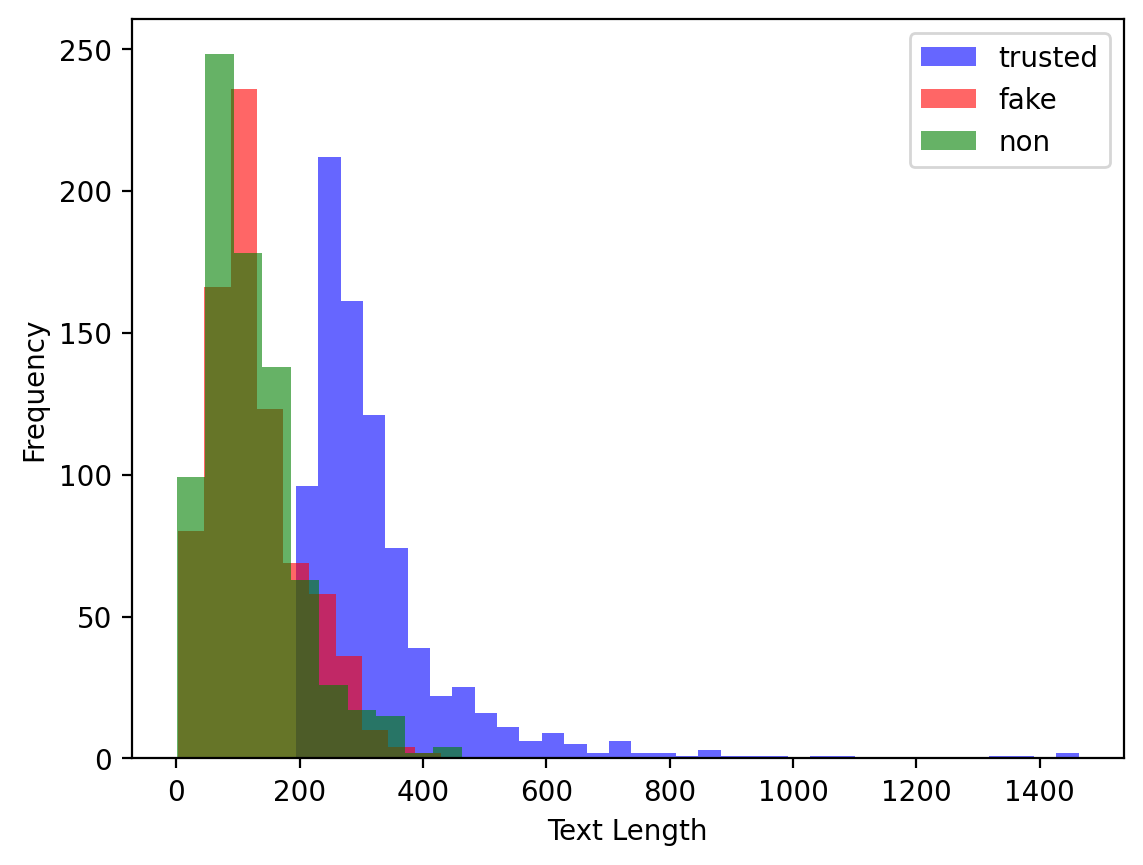

In [7]:
df[df.label=='trusted'].text_length.plot(bins=35, kind='hist', color='blue',
                                       label='trusted', alpha=0.6)
df[df.label == 'fake'].text_length.plot(kind='hist', color='red',
                                       label='fake', alpha=0.6)
df[df.label == 'non'].text_length.plot(kind='hist', color='green',
                                       label='non', alpha=0.6)
plt.legend()
plt.xlabel("Text Length")
plt.show()


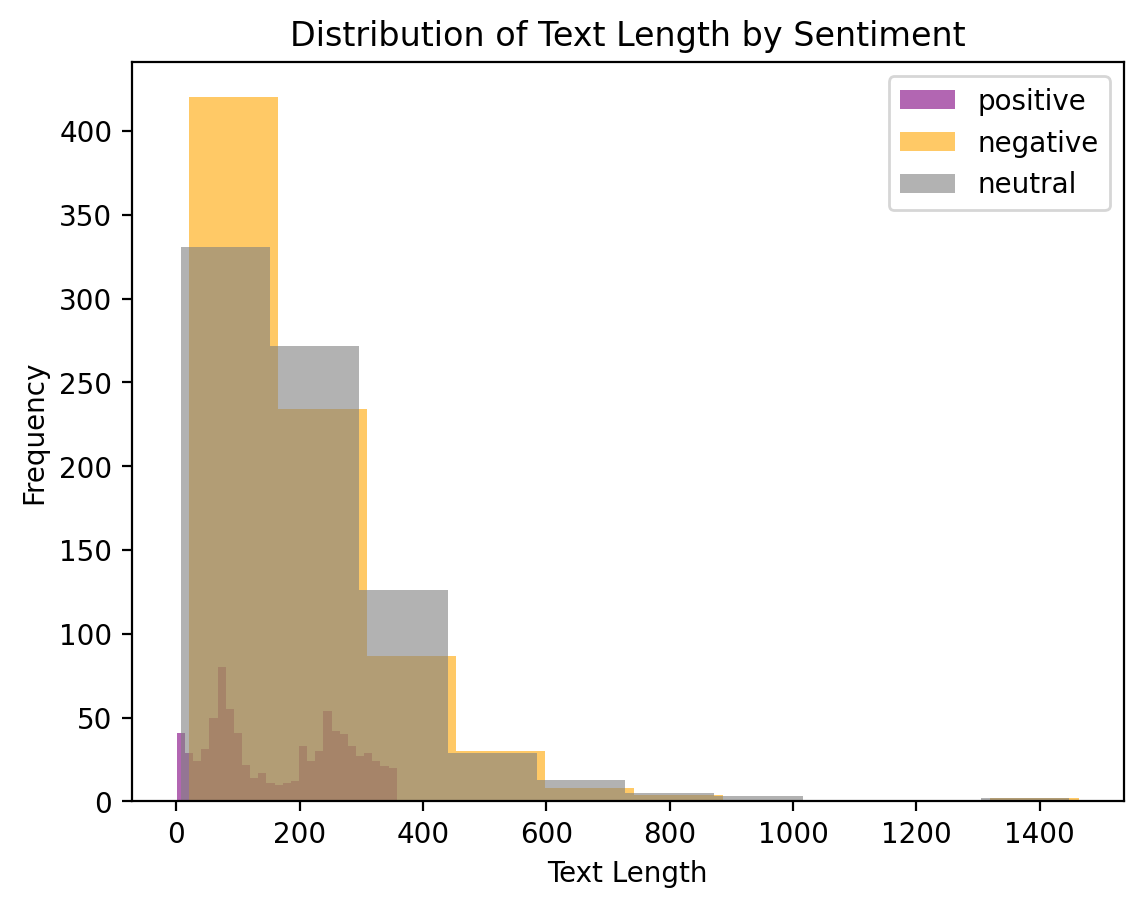

In [8]:
df[df.sentimen == 'positive'].text_length.plot(bins=35, kind='hist', color='purple',
                                               label='positive', alpha=0.6)
df[df.sentimen == 'negative'].text_length.plot(kind='hist', color='orange',
                                               label='negative', alpha=0.6)
df[df.sentimen == 'neutral'].text_length.plot(kind='hist', color='grey',
                                              label='neutral', alpha=0.6)

plt.legend()
plt.xlabel("Text Length")
plt.ylabel("Frequency")
plt.title("Distribution of Text Length by Sentiment")
plt.show()

In [9]:
df.groupby(['label']).count()

,username,rate,date,sentimen,reviews,produk,text_length
label,,,,,,,
fake,784,784,784,784,784,784,784
non,790,790,790,790,790,790,790
trusted,822,822,822,822,822,822,822


<Axes: xlabel='label', ylabel='count'>

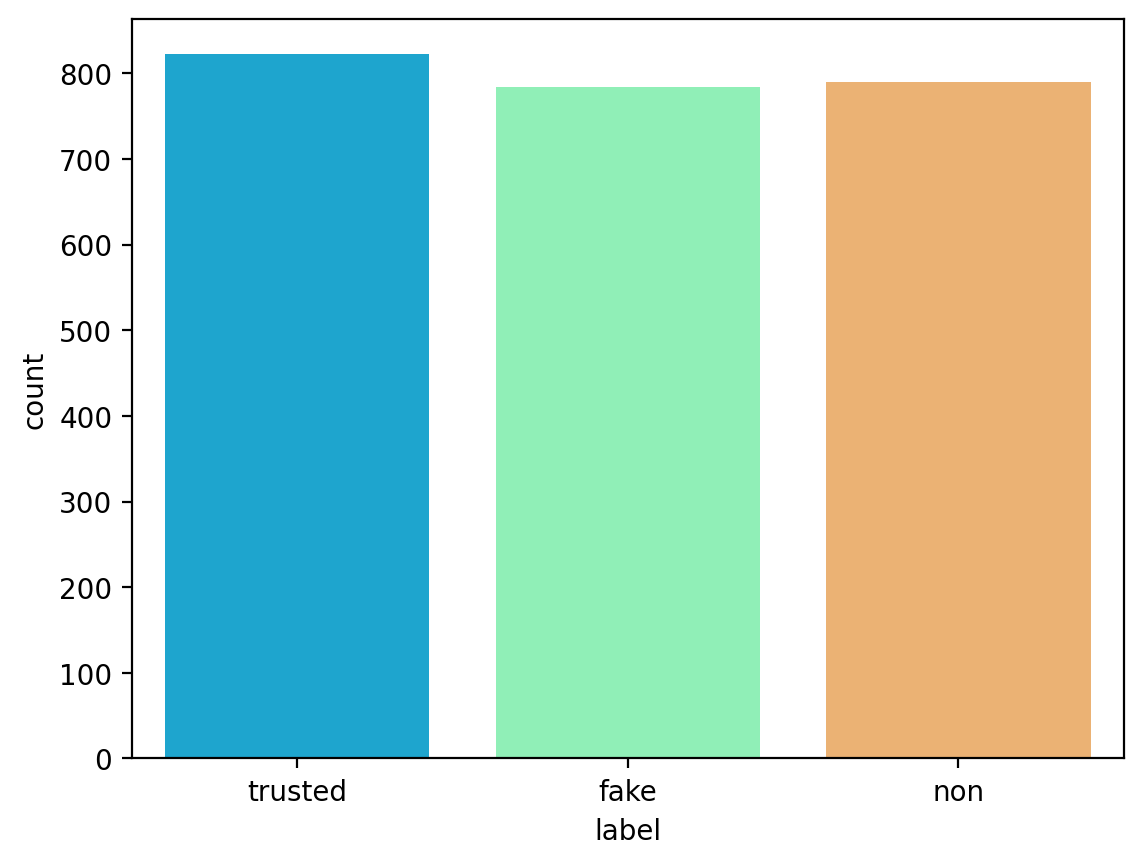

In [10]:
sns.countplot(x='label', data=df, palette='rainbow')

<Axes: xlabel='sentimen', ylabel='count'>

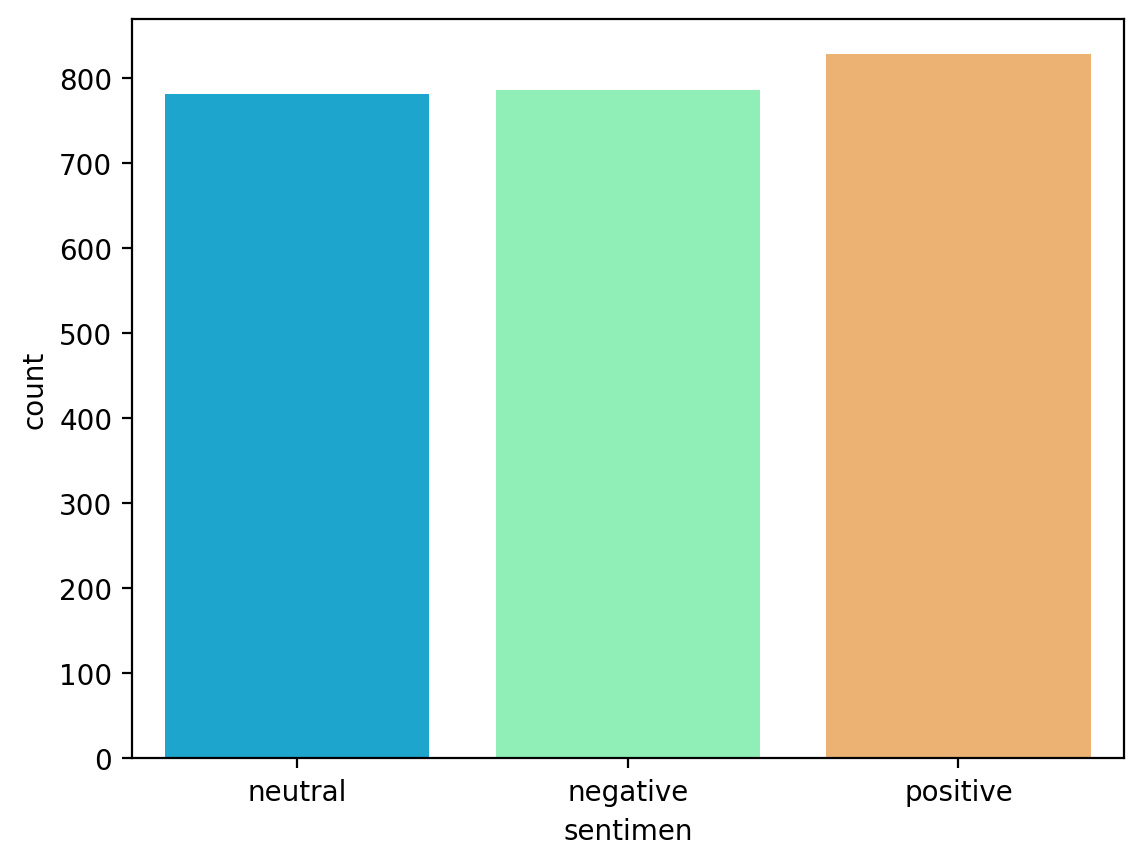

In [11]:
sns.countplot(x='sentimen', data=df, palette='rainbow')

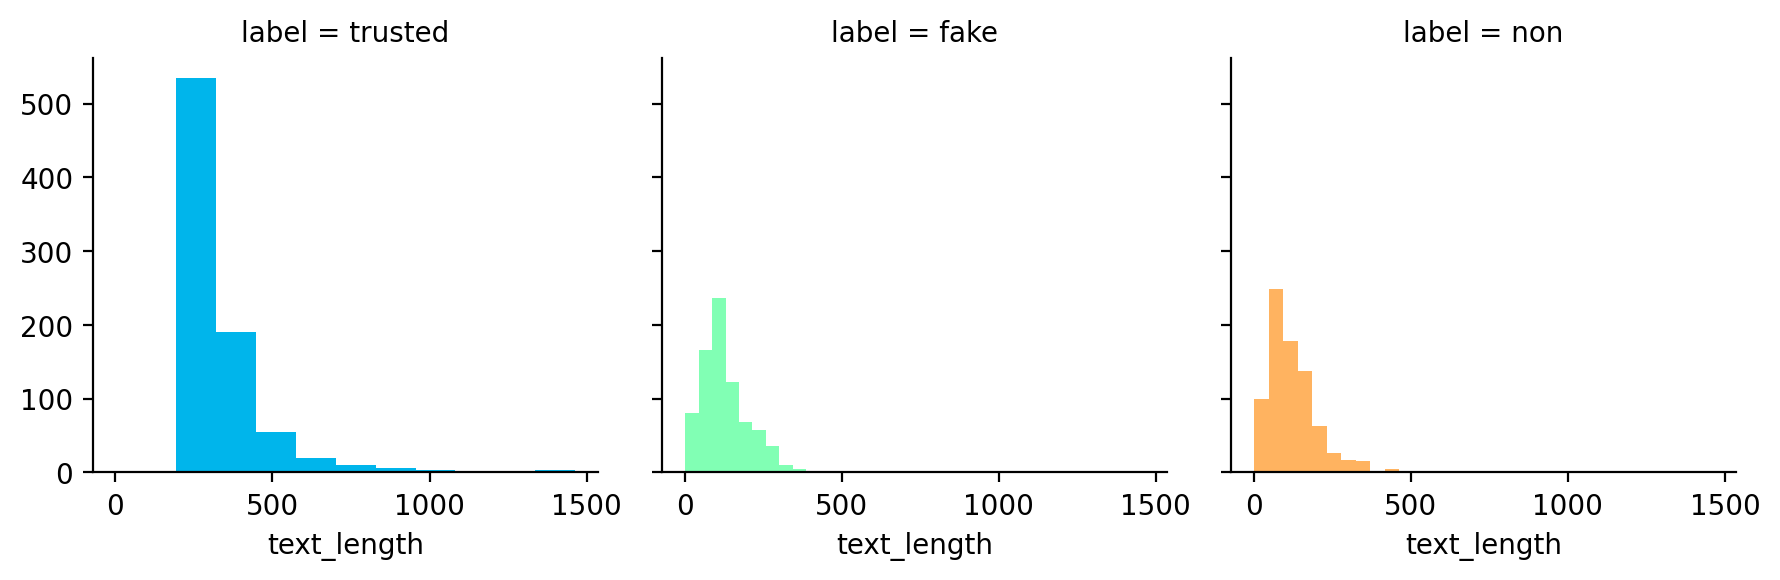

In [12]:
g = sns.FacetGrid(df, col='label', hue='label', palette='rainbow')
g.map(plt.hist, 'text_length')
plt.show()

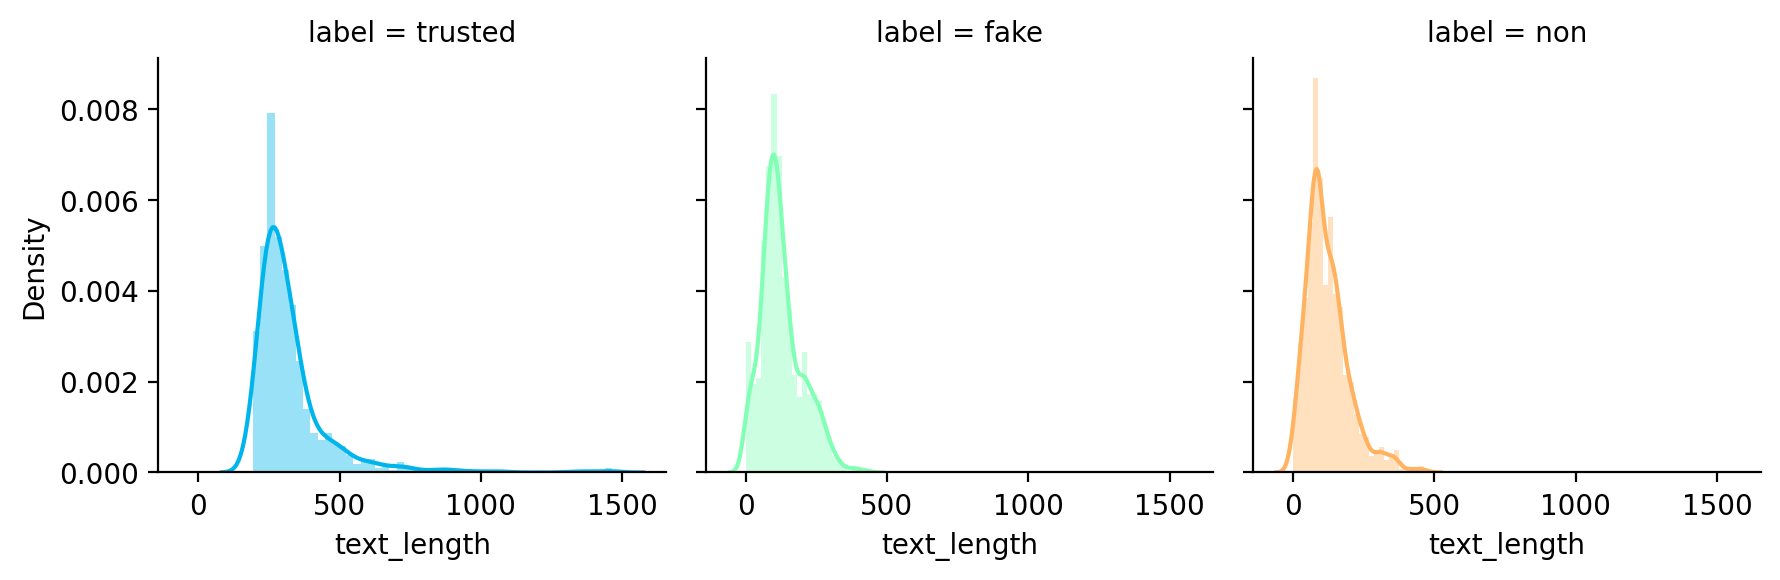

In [13]:
g = sns.FacetGrid(df, col='label', hue='label', palette='rainbow')
g.map(sns.distplot, 'text_length')

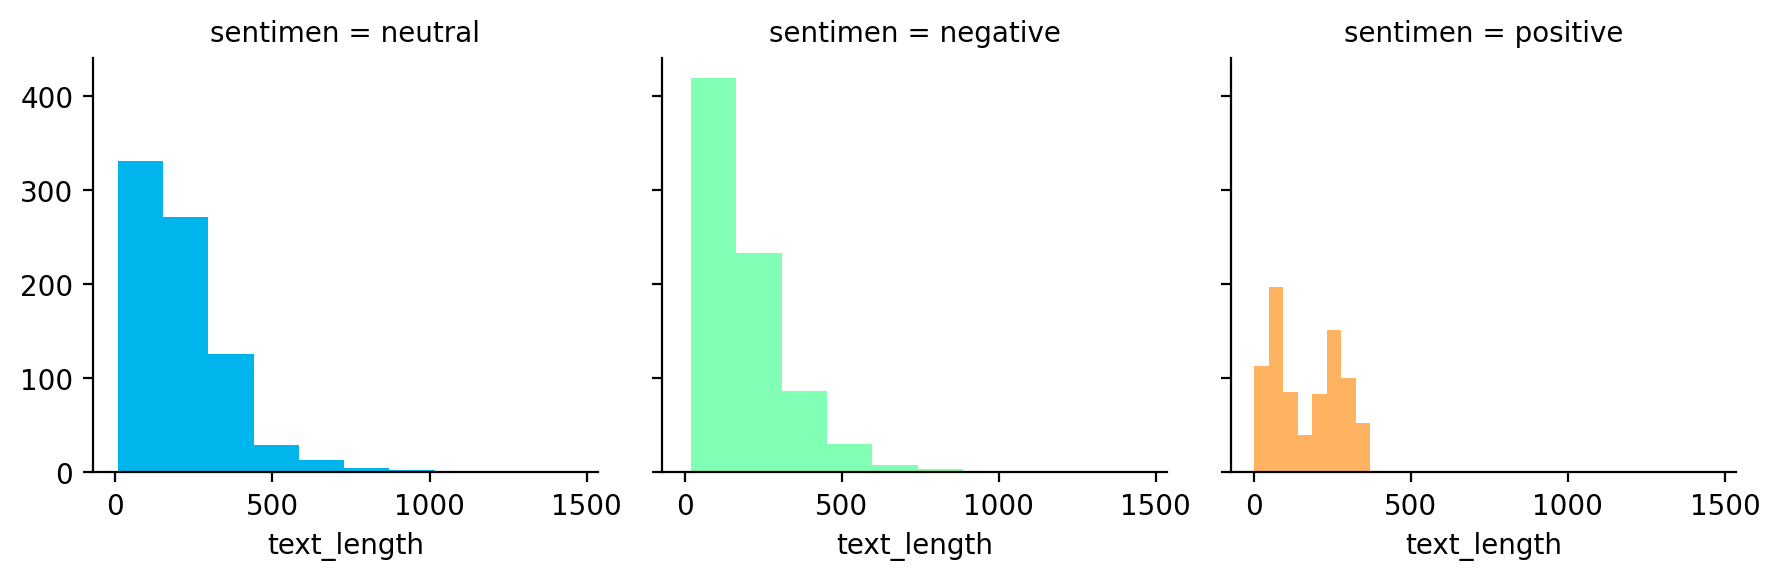

In [15]:
g = sns.FacetGrid(df, col='sentimen', hue='sentimen', palette='rainbow')
g.map(plt.hist, 'text_length')

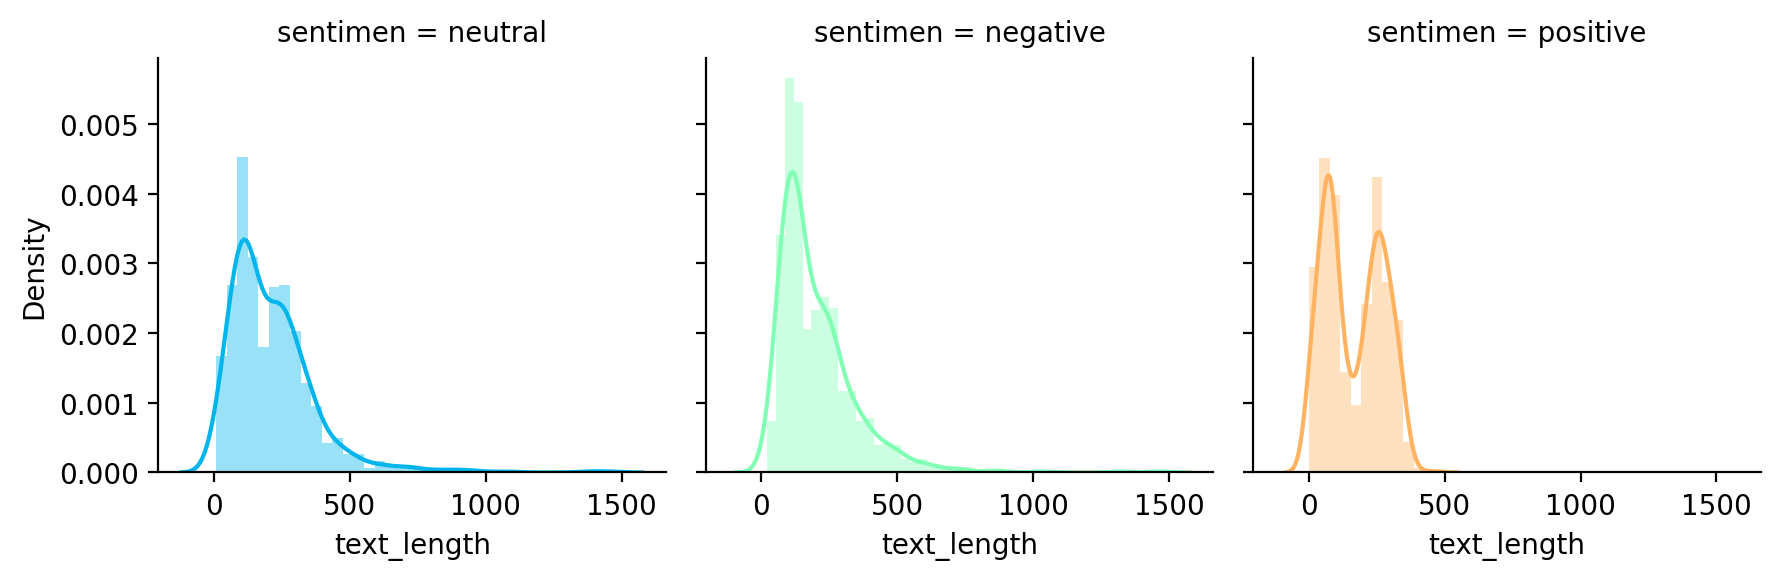

In [16]:
g = sns.FacetGrid(df, col='sentimen', hue='sentimen', palette='rainbow')
g.map(sns.distplot, 'text_length')

## Find Missing Value

In [19]:

print('Jumlah missing values disetiap kolom:\n', df.isnull().sum())

Jumlah missing values disetiap kolom:
 username       0
rate           0
date           0
label          0
sentimen       0
reviews        0
produk         0
text_length    0
dtype: int64


## Duplicate Handling

In [47]:
# Check for duplicates
duplicates = df.duplicated()

print("\nDuplicate Rows:")
print(df[duplicates])


Duplicate Rows:
Empty DataFrame
Columns: [username, rate, date, label, sentimen, reviews, produk, text_length, anomaly_score]
Index: []


In [48]:
# df = df.drop_duplicates()

## Outliers Handling



In [49]:
df['text_length'] = df['reviews'].apply(len)

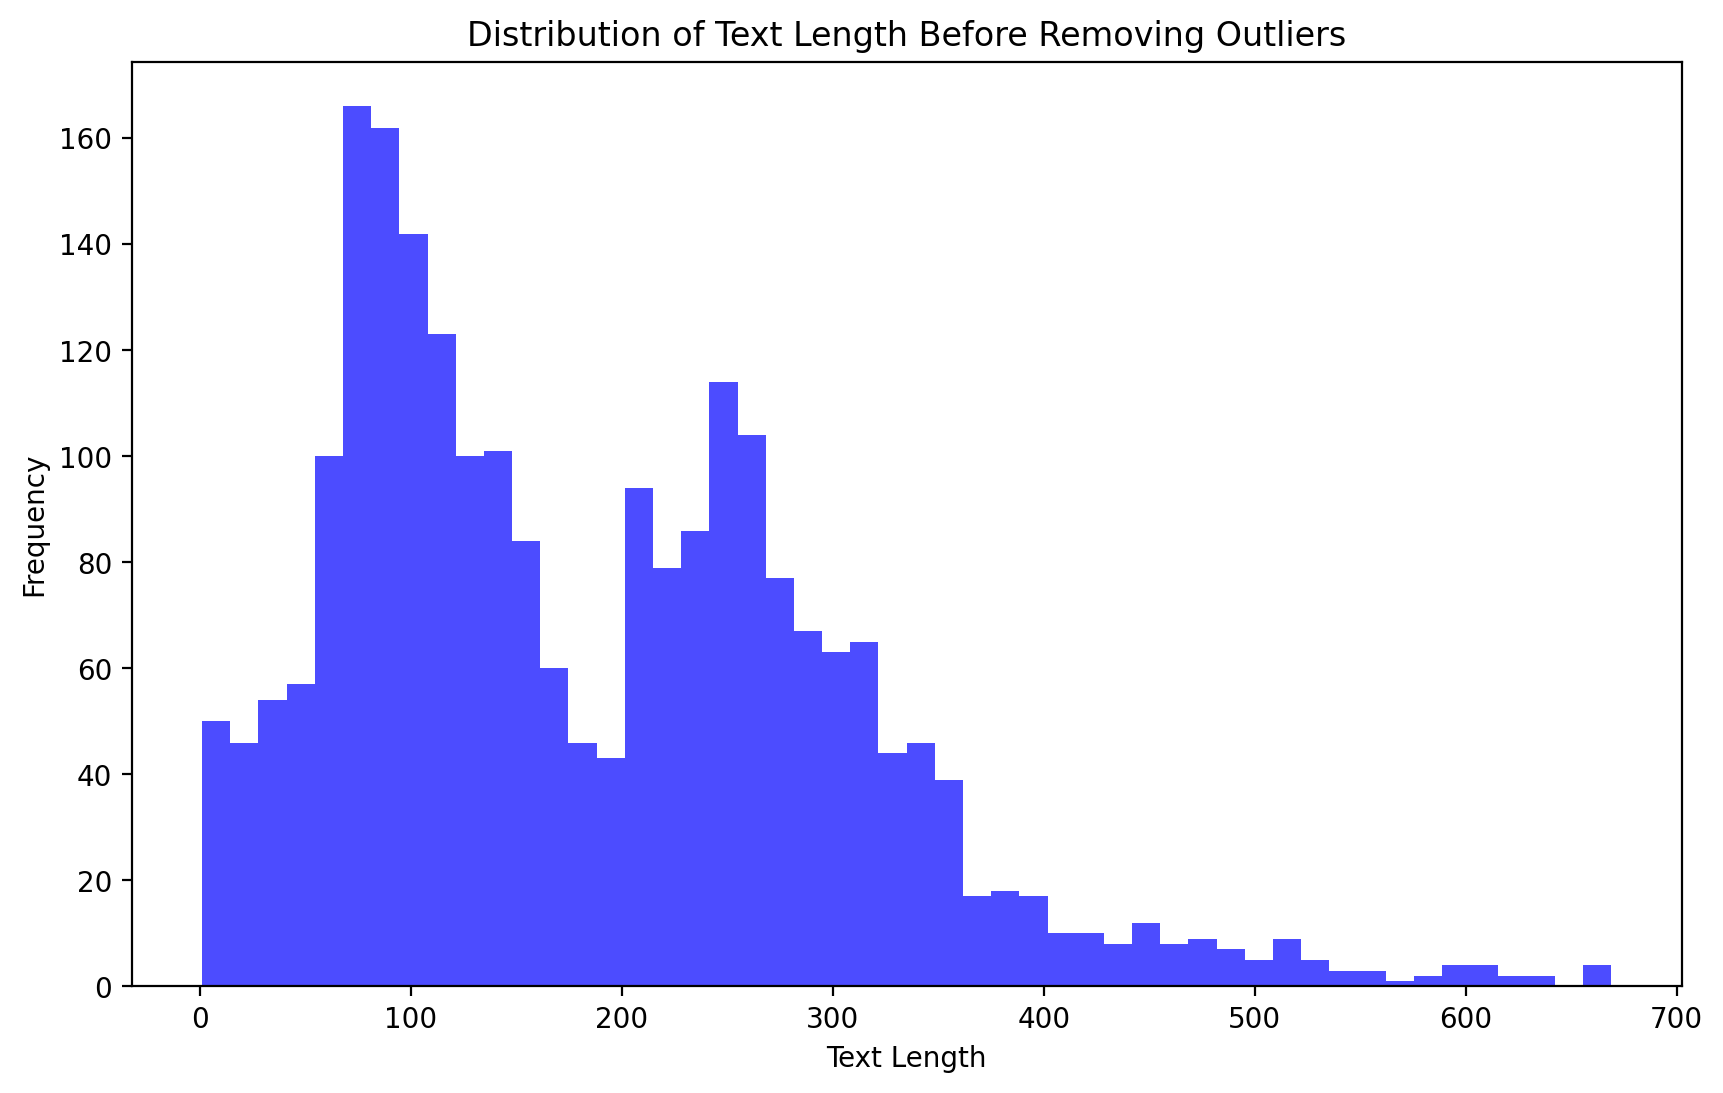

In [50]:
# Plot sebelum menghapus outlier
plt.figure(figsize=(10, 6))
df['text_length'].plot(kind='hist', bins=50, color='blue', alpha=0.7)
plt.title('Distribution of Text Length Before Removing Outliers')
plt.xlabel('Text Length')
plt.ylabel('Frequency')
plt.show()

In [51]:
df.label.value_counts()

label
trusted    798
non        790
fake       784
Name: count, dtype: int64

In [52]:
df.sentimen.value_counts()

sentimen
positive    828
negative    777
neutral     767
Name: count, dtype: int64

### Review

In [ ]:
# Q1 = df[df['label'] == 'fake']['text_length'].quantile(0.25)
# Q3 = df[df['label'] == 'fake']['text_length'].quantile(0.75)
# IQR = Q3 - Q1

# df = df[~((df['text_length'] < (Q1-1.5*IQR)) | (df['text_length'] > (Q3+1.5*IQR)))]

In [ ]:
# Q1 = df[df['label'] == 'trusted']['text_length'].quantile(0.25)
# Q3 = df[df['label'] == 'trusted']['text_length'].quantile(0.75)
# IQR = Q3 - Q1

# df = df[~((df['text_length'] < (Q1-1.5*IQR)) | (df['text_length'] > (Q3+1.5*IQR)))]

In [ ]:
# Q1 = df[df['label'] == 'non']['text_length'].quantile(0.25)
# Q3 = df[df['label'] == 'non']['text_length'].quantile(0.75)
# IQR = Q3 - Q1

# df = df[~((df['text_length'] < (Q1-1.5*IQR)) | (df['text_length'] > (Q3+1.5*IQR)))]

<Axes: xlabel='label', ylabel='text_length'>

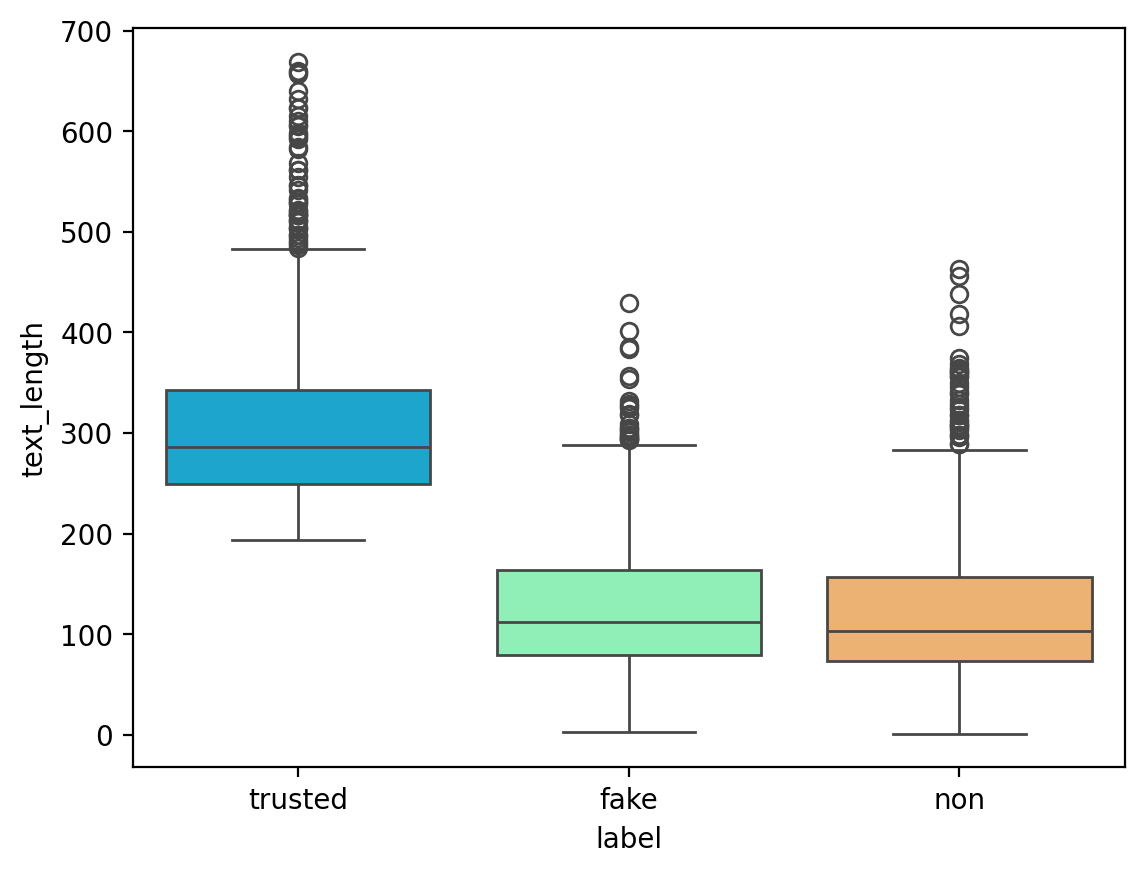

In [53]:
sns.boxplot(x='label',y='text_length',data=df,palette='rainbow')

### Sentimen

In [ ]:
# Q1 = df[df['sentimen'] == 'positive']['text_length'].quantile(0.25)
# Q3 = df[df['sentimen'] == 'positive']['text_length'].quantile(0.75)
# IQR = Q3 - Q1

# df = df[~((df['text_length'] < (Q1-1.5*IQR)) | (df['text_length'] > (Q3+1.5*IQR)))]

In [ ]:
# Q1 = df[df['sentimen'] == 'negative']['text_length'].quantile(0.25)
# Q3 = df[df['sentimen'] == 'negative']['text_length'].quantile(0.75)
# IQR = Q3 - Q1

# df = df[~((df['text_length'] < (Q1-1.5*IQR)) | (df['text_length'] > (Q3+1.5*IQR)))]

In [ ]:
# Q1 = df[df['sentimen'] == 'neutral']['text_length'].quantile(0.25)
# Q3 = df[df['sentimen'] == 'neutral']['text_length'].quantile(0.75)
# IQR = Q3 - Q1

# df = df[~((df['text_length'] < (Q1-1.5*IQR)) | (df['text_length'] > (Q3+1.5*IQR)))]

<Axes: xlabel='sentimen', ylabel='text_length'>

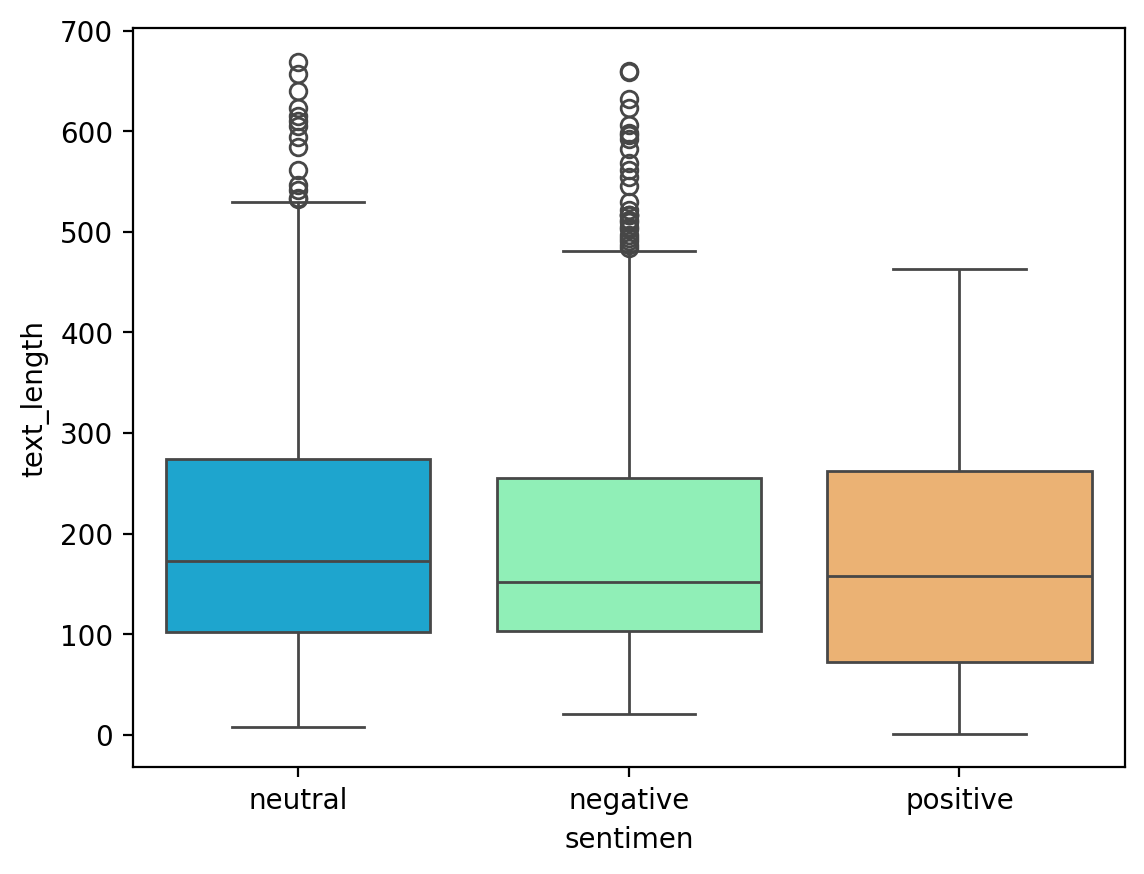

In [54]:
sns.boxplot(x='sentimen',y='text_length',data=df,palette='rainbow')

### Using Isolation Forest

In [57]:
#Isolation Forest

from sklearn.ensemble import IsolationForest
iso_forest = IsolationForest(contamination=0.01, random_state=42)
df['anomaly_score'] = iso_forest.fit_predict(df[['text_length']])
df = df[df['anomaly_score'] == 1]



## Show Final Distrubution & Outlier

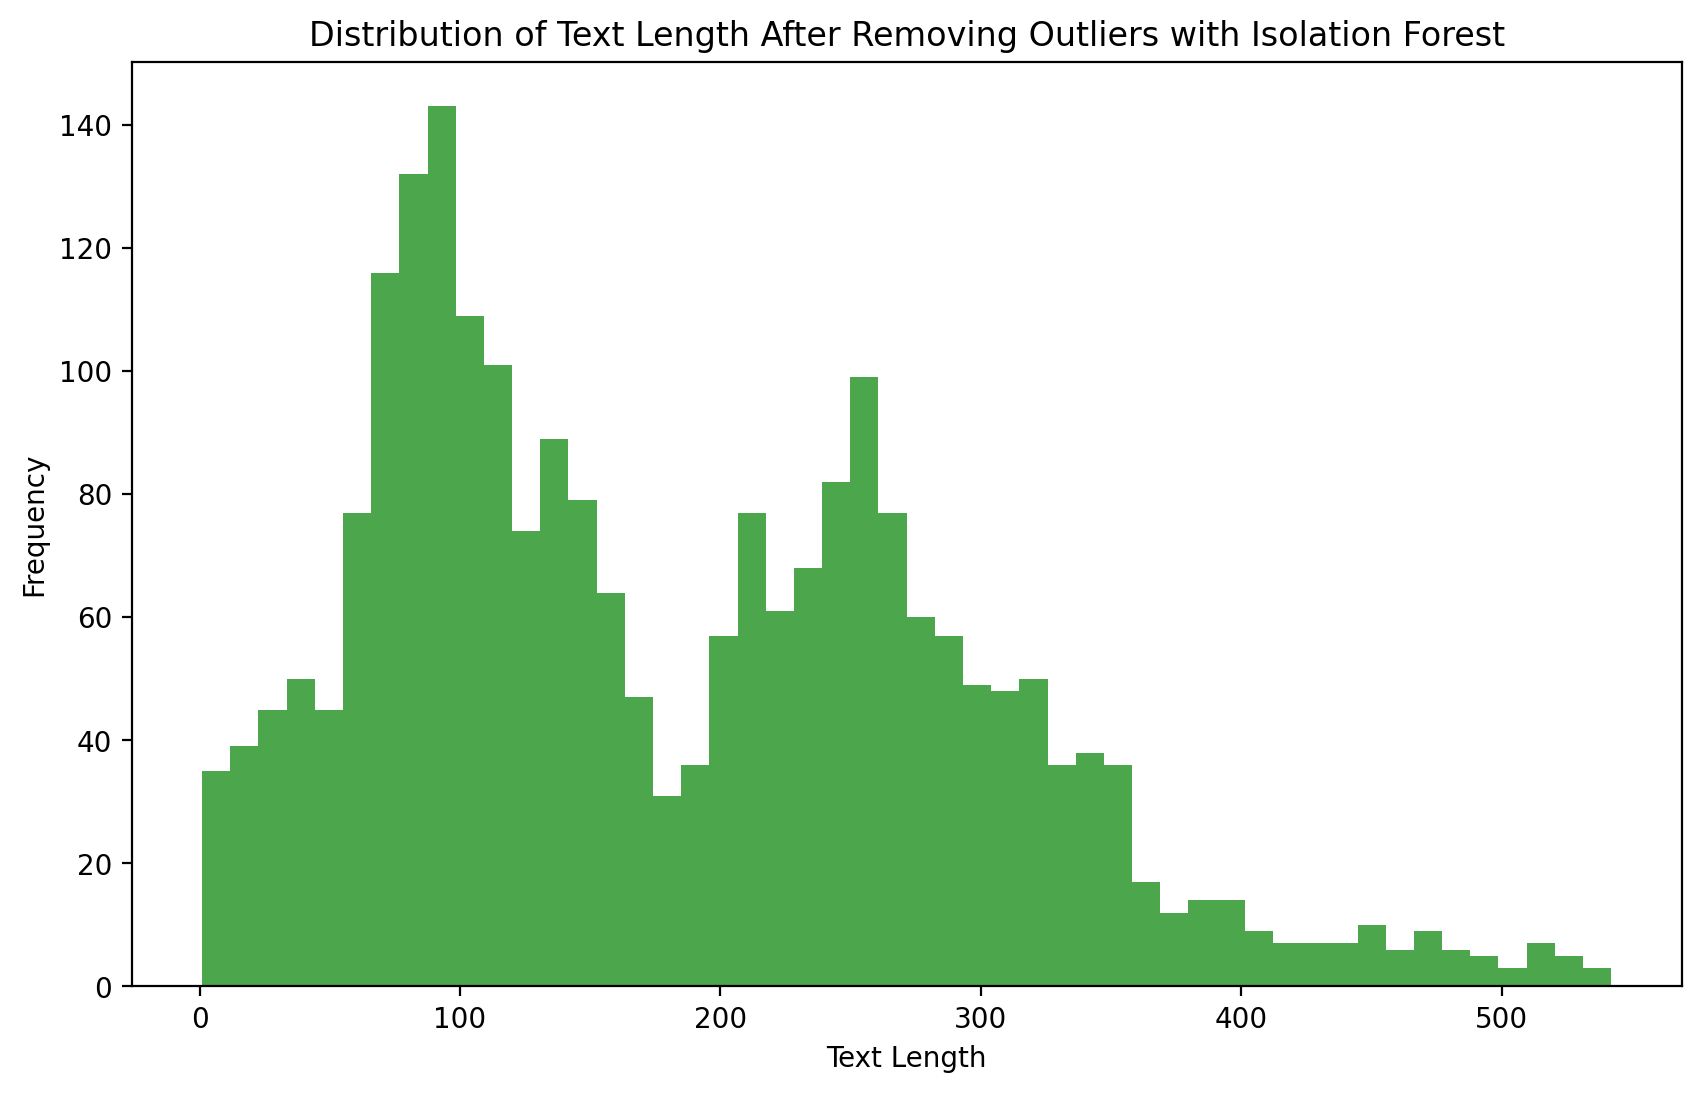

In [58]:
plt.figure(figsize=(10, 6))
df['text_length'].plot(kind='hist', bins=50, color='green', alpha=0.7)
plt.title('Distribution of Text Length After Removing Outliers with Isolation Forest')
plt.xlabel('Text Length')
plt.ylabel('Frequency')
plt.show()

### Review

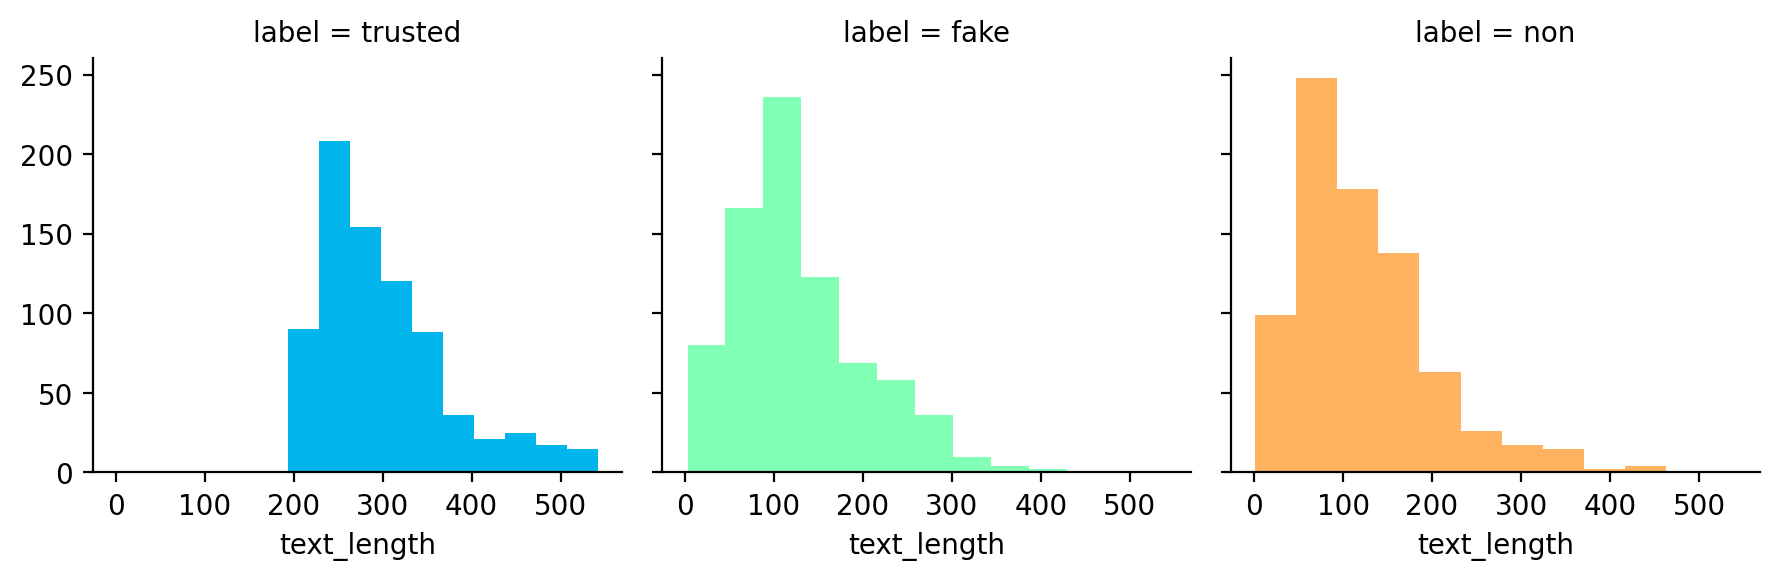

In [59]:
g = sns.FacetGrid(df, col='label', hue='label', palette='rainbow')
g.map(plt.hist, 'text_length')

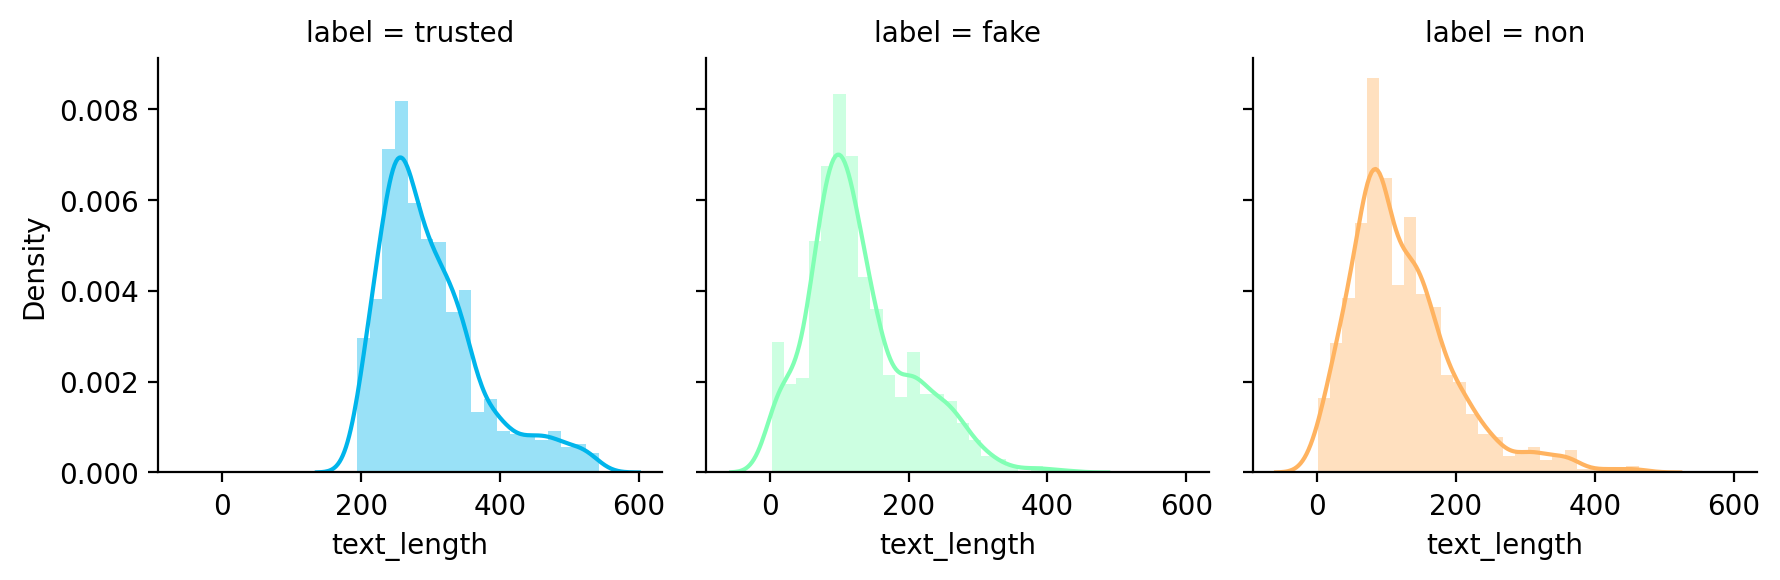

In [60]:
g = sns.FacetGrid(df, col='label', hue='label', palette='rainbow')
g.map(sns.distplot, 'text_length')

<Axes: xlabel='label', ylabel='text_length'>

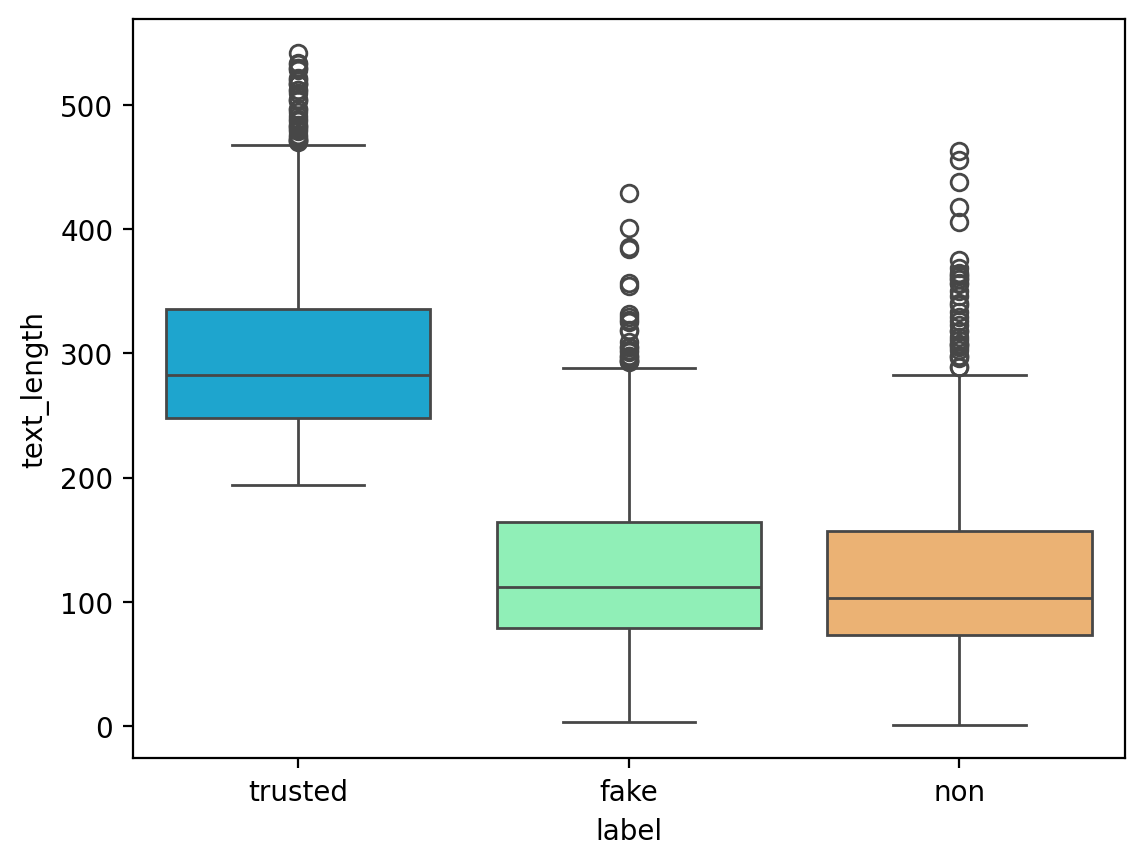

In [61]:
sns.boxplot(x='label',y='text_length',data=df,palette='rainbow')

### Sentimen

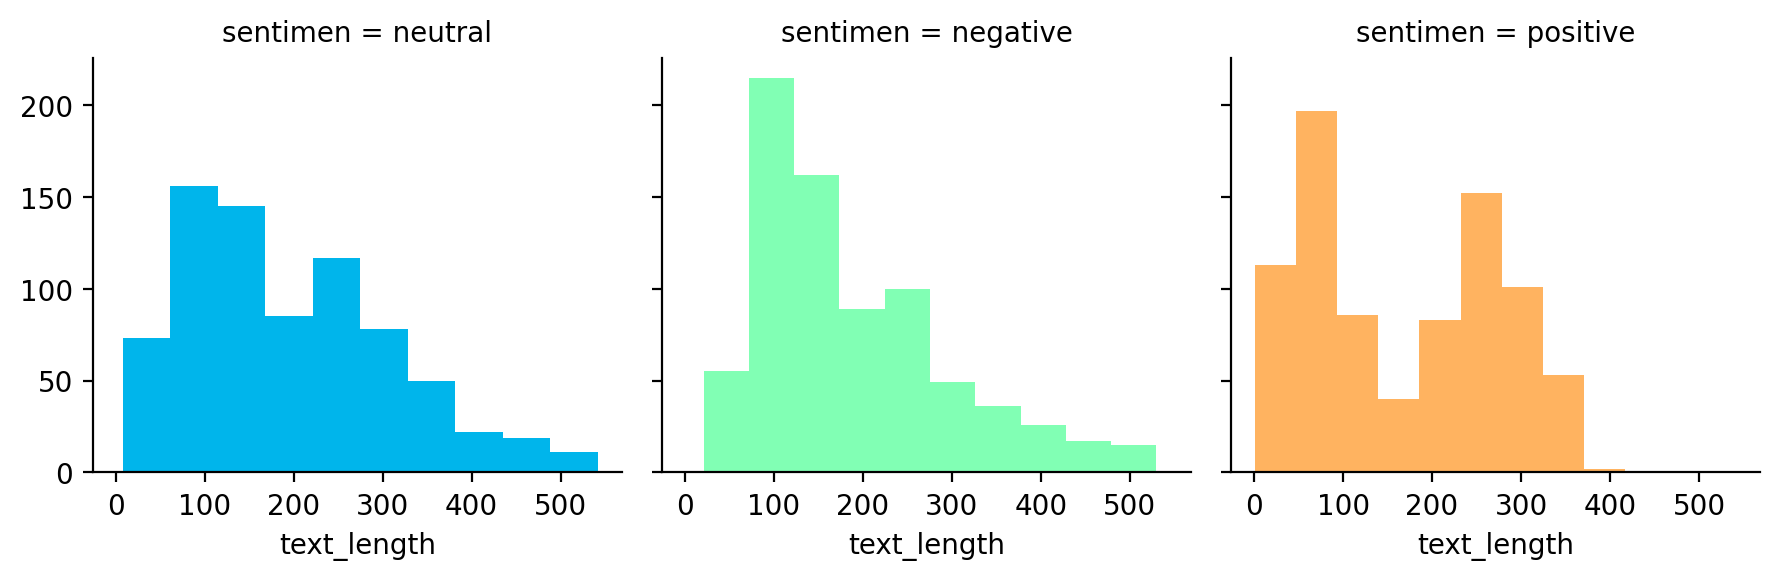

In [62]:
g = sns.FacetGrid(df, col='sentimen', hue='sentimen', palette='rainbow')
g.map(plt.hist, 'text_length')

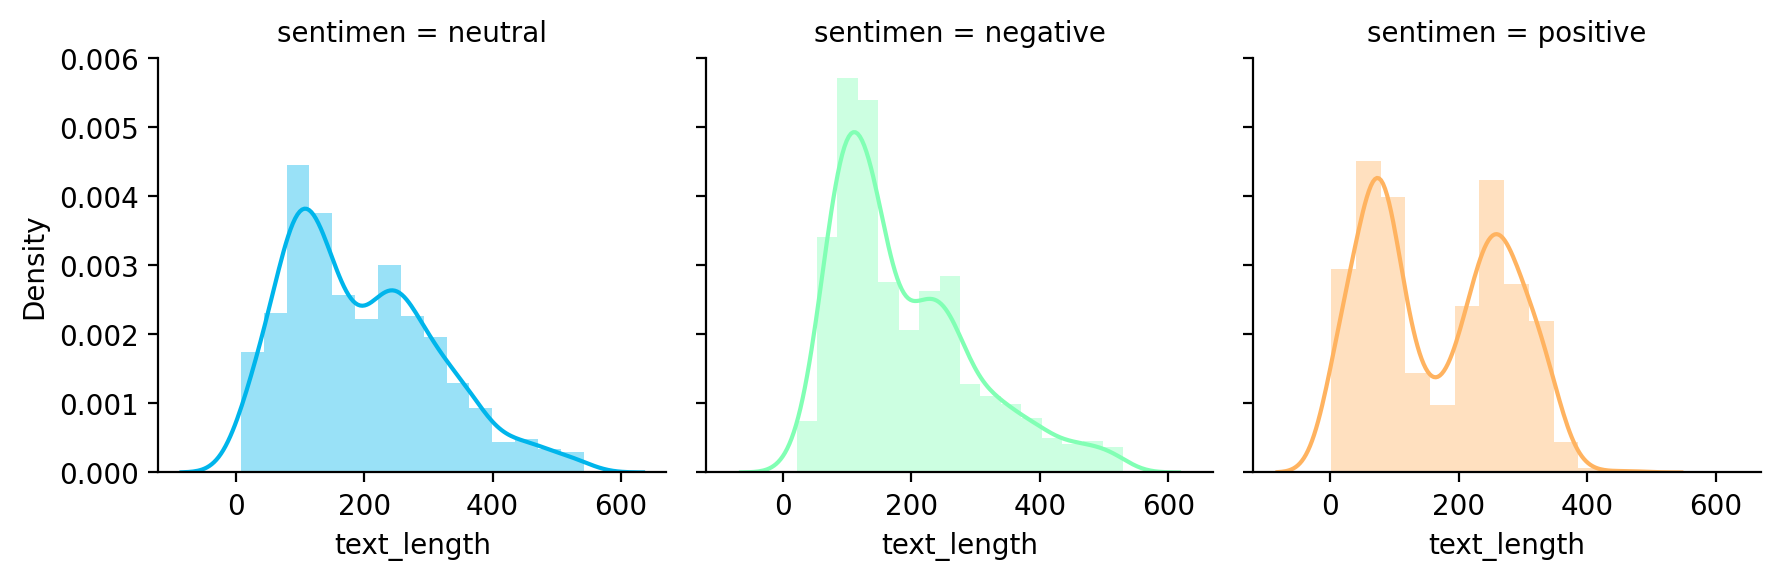

In [63]:
g = sns.FacetGrid(df, col='sentimen', hue='sentimen', palette='rainbow')
g.map(sns.distplot, 'text_length')

<Axes: xlabel='sentimen', ylabel='text_length'>

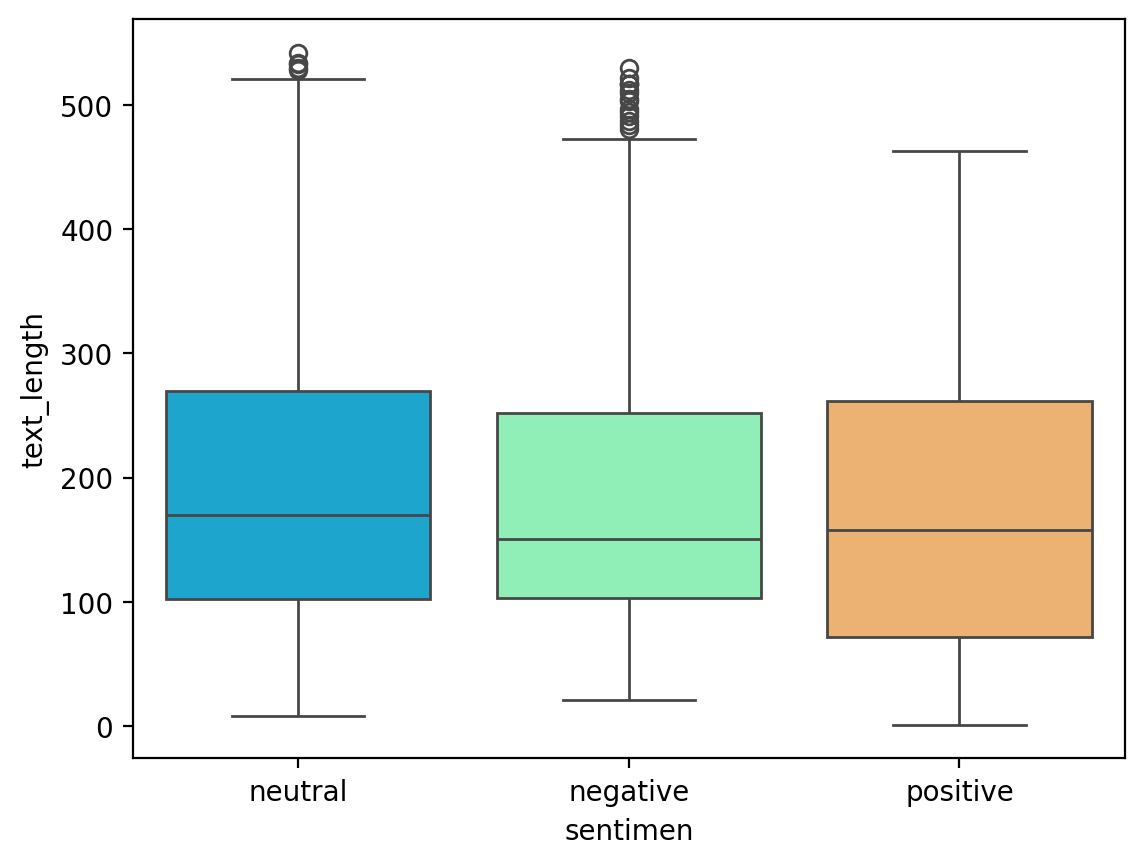

In [64]:
sns.boxplot(x='sentimen',y='text_length',data=df,palette='rainbow')

## Imbalance Class Handling

### Review

In [65]:
df.label.value_counts()

label
non        790
fake       784
trusted    774
Name: count, dtype: int64

In [67]:
# Resample data
label_trusted = resample(df[df['label'] == 'trusted'],
                                 replace=True,
                                 n_samples=800,
                                 random_state=123)

label_fake = resample(df[df['label'] == 'fake'],
                                 replace=True,
                                 n_samples=800,
                                 random_state=123)

label_non = resample(df[df['label'] == 'non'],
                                 replace=True,
                                 n_samples=800,
                                 random_state=123)

# Gabung ulang
df = pd.concat([label_trusted, label_fake, label_non])

df.label.value_counts()

label
trusted    800
fake       800
non        800
Name: count, dtype: int64

### Sentimen


In [68]:
df.sentimen.value_counts()

sentimen
positive    899
negative    764
neutral     737
Name: count, dtype: int64

In [69]:
# Resample data
sentimen_neutral = resample(df[df['sentimen'] == 'neutral'],
                                 replace=True,
                                 n_samples=800,
                                 random_state=123)

sentimen_positive = resample(df[df['sentimen'] == 'positive'],
                                 replace=True,
                                 n_samples=800,
                                 random_state=123)

sentimen_negative = resample(df[df['sentimen'] == 'negative'],
                                 replace=True,
                                 n_samples=800,
                                 random_state=123)

# Gabung ulang
df = pd.concat([sentimen_neutral, sentimen_positive, sentimen_negative])

df.sentimen.value_counts()

sentimen
neutral     800
positive    800
negative    800
Name: count, dtype: int64

# Data Preparation

## Features Engeneering


## Data Cleanning

### To Lowercase

In [90]:
# merubah jenis huruf menjadi huruf kecil
def lowercase(review_text):
  low = review_text.lower()
  return low

df['lowercase_reviews'] = df['reviews'].apply(lambda low:lowercase(str(low)))

In [91]:
df[['reviews', 'lowercase_reviews']]

,reviews,lowercase_reviews
0,"Waktu smp aku pakai ss ini selama ±2 tahun, te...","waktu smp aku pakai ss ini selama ±2 tahun, te..."
1,Aku ga terlalu cocok pake produk ini terlebih ...,aku ga terlalu cocok pake produk ini terlebih ...
2,"Sunscreen pertama aku sewaktu kenal skincare, ...","sunscreen pertama aku sewaktu kenal skincare, ..."
3,Teksturnya agak watery gitu\nDiblendnya agak l...,teksturnya agak watery gitu\ndiblendnya agak l...
4,"ini adalah suncreen pertamaku , dulu cocok ban...","ini adalah suncreen pertamaku , dulu cocok ban..."
...,...,...
2391,apa sih yang bikin kusam wajah?,apa sih yang bikin kusam wajah?
2392,gimana caranya ngebedain skincare yang palsu ?...,gimana caranya ngebedain skincare yang palsu ?...
2393,kenapa ya ada orang yang beli skincare tapi ma...,kenapa ya ada orang yang beli skincare tapi ma...
2394,apakah bener skincare abal-abal bikin kusam,apakah bener skincare abal-abal bikin kusam


### Remove Emoji

In [92]:
# menghapus emoji menggunakan regex dan nilai unicode dari emoji

def remove_emoji(review_text):
    emoji_pattern = re.compile("["
                           u"\U0001F600-\U0001F64F"  # emoticons
                           u"\U0001F300-\U0001F5FF"  # symbols & pictographs
                           u"\U0001F680-\U0001F6FF"  # transport & map symbols
                           u"\U00002702-\U000027B0"
                           u"\U000024C2-\U0001F251"
                           u"\U0001f926-\U0001f937"
                           u"\U00010000-\U0010ffff"
                           "]+", flags=re.UNICODE)
    return emoji_pattern.sub(r'', review_text)

df['no_emoji_reviews'] = df['lowercase_reviews'].apply(lambda emoji: remove_emoji(emoji))

In [105]:
df[['reviews', 'no_emoji_reviews']]

,reviews,no_emoji_reviews
0,"Waktu smp aku pakai ss ini selama ±2 tahun, te...","waktu smp aku pakai ss ini selama ±2 tahun, te..."
1,Aku ga terlalu cocok pake produk ini terlebih ...,aku ga terlalu cocok pake produk ini terlebih ...
2,"Sunscreen pertama aku sewaktu kenal skincare, ...","sunscreen pertama aku sewaktu kenal skincare, ..."
3,Teksturnya agak watery gitu\nDiblendnya agak l...,teksturnya agak watery gitu\ndiblendnya agak l...
4,"ini adalah suncreen pertamaku , dulu cocok ban...","ini adalah suncreen pertamaku , dulu cocok ban..."
...,...,...
2391,apa sih yang bikin kusam wajah?,apa sih yang bikin kusam wajah?
2392,gimana caranya ngebedain skincare yang palsu ?...,gimana caranya ngebedain skincare yang palsu ?...
2393,kenapa ya ada orang yang beli skincare tapi ma...,kenapa ya ada orang yang beli skincare tapi ma...
2394,apakah bener skincare abal-abal bikin kusam,apakah bener skincare abal-abal bikin kusam


### Remove Hastag


In [96]:
# menghapus hashtag dari ulasan yang biasanya digunakan oleh pengguna untuk memberikan tagar

def remove_hashtag(review_text, default_replace=""):
  hashtag = re.sub(r'#\w+', default_replace, review_text)
  return hashtag

df['no_hastag_reviews'] = df['no_emoji_reviews'].apply(lambda hashtag: remove_hashtag(hashtag))

In [104]:
df[['reviews','no_hastag_reviews',]]

,reviews,no_hastag_reviews
0,"Waktu smp aku pakai ss ini selama ±2 tahun, te...","waktu smp aku pakai ss ini selama ±2 tahun, te..."
1,Aku ga terlalu cocok pake produk ini terlebih ...,aku ga terlalu cocok pake produk ini terlebih ...
2,"Sunscreen pertama aku sewaktu kenal skincare, ...","sunscreen pertama aku sewaktu kenal skincare, ..."
3,Teksturnya agak watery gitu\nDiblendnya agak l...,teksturnya agak watery gitu\ndiblendnya agak l...
4,"ini adalah suncreen pertamaku , dulu cocok ban...","ini adalah suncreen pertamaku , dulu cocok ban..."
...,...,...
2391,apa sih yang bikin kusam wajah?,apa sih yang bikin kusam wajah?
2392,gimana caranya ngebedain skincare yang palsu ?...,gimana caranya ngebedain skincare yang palsu ?...
2393,kenapa ya ada orang yang beli skincare tapi ma...,kenapa ya ada orang yang beli skincare tapi ma...
2394,apakah bener skincare abal-abal bikin kusam,apakah bener skincare abal-abal bikin kusam


### Remove Punctuation & Number

In [109]:
# menghapus angka dalam ulasan

def remove_number(review_text, default_replace=" "):
  num = re.sub(r'\d+', default_replace, review_text)
  return num

df['no_number_reviews'] = df['no_hastag_reviews'].apply(lambda num: remove_number(num))

In [114]:
# menghapus tanda baca

def remove_punctuation(review_text, default_text=" "):
  list_punct = string.punctuation
  delete_punct = str.maketrans(list_punct,' '*len(list_punct))
  new_review = ' '.join(review_text.translate(delete_punct).split())

  return new_review

df['no_atribut_reviews'] = df['no_number_reviews'].apply(lambda punct: remove_punctuation(punct))

In [115]:
# menghapus superscript dalam ulasan yang biasa digunakan oleh pengguna dalam mengulangi kata

def remove_superscript(review_text):
  number = re.compile("["u"\U00002070"
                      u"\U000000B9"
                      u"\U000000B2-\U000000B3"
                      u"\U00002074-\U00002079"
                      u"\U0000207A-\U0000207E"
                      u"U0000200D"
                      "]+", flags=re.UNICODE)
  return number.sub(r'', review_text)

df['no_atribut_reviews'] = df['no_atribut_reviews'].apply(lambda num: remove_superscript(num))

In [128]:
def remove_text_special(review_text):
    # Hapus tab, newline, dan backslash
    review_text = review_text.replace('\\t'," ").replace('\\n'," ").replace('\\u'," ").replace('\\',"")

    # Hapus simbol
    review_text = re.sub(r'[^a-zA-Z\s]', '', review_text)

    # Hapus karakter non-ASCII
    review_text = review_text.encode('ascii', 'replace').decode('ascii')

    # Hapus URL
    review_text = re.sub(r'http\S+', '', review_text)

    return review_text

# Contoh pemanggilan fungsi pada kolom 'no_atribut_reviews'
df['no_atribut_reviews'] = df['no_atribut_reviews'].apply(remove_text_special)


In [129]:
df[['reviews','no_atribut_reviews',]]

,reviews,no_atribut_reviews
0,"Waktu smp aku pakai ss ini selama ±2 tahun, te...",waktu smp aku pakai ss ini selama tahun terus...
1,Aku ga terlalu cocok pake produk ini terlebih ...,aku ga terlalu cocok pake produk ini terlebih ...
2,"Sunscreen pertama aku sewaktu kenal skincare, ...",sunscreen pertama aku sewaktu kenal skincare f...
3,Teksturnya agak watery gitu\nDiblendnya agak l...,teksturnya agak watery gitu diblendnya agak lu...
4,"ini adalah suncreen pertamaku , dulu cocok ban...",ini adalah suncreen pertamaku dulu cocok bange...
...,...,...
2391,apa sih yang bikin kusam wajah?,apa sih yang bikin kusam wajah
2392,gimana caranya ngebedain skincare yang palsu ?...,gimana caranya ngebedain skincare yang palsu b...
2393,kenapa ya ada orang yang beli skincare tapi ma...,kenapa ya ada orang yang beli skincare tapi ma...
2394,apakah bener skincare abal-abal bikin kusam,apakah bener skincare abal abal bikin kusam


### Remove Repetition

In [130]:
# melakukan pembatasan jumlah huruf menjadi dua untuk mengembalikan kata ke bentuk awal
# dan menghindari terjadinya kata ganda yang memiliki arti sama tetapi berbeda penulisan

def word_repetition(review_text):
  review = re.sub(r'(.)\1+', r'\1\1', review_text)
  return review

df['no_repetition_reviews'] = df['no_atribut_reviews'].apply(lambda word: word_repetition(word))

In [131]:
# melakukan pembatasan kata berulang menjadi satu kali, seperti suka suka -> suka

def repetition(review_text):
  repeat = re.sub(r'\b(\w+)(?:\W\1\b)+', r'\1',review_text, flags=re.IGNORECASE)
  return repeat

df['no_repetition_reviews'] = df['no_repetition_reviews'].apply(lambda word: repetition(word))

In [132]:
df[['reviews','no_repetition_reviews',]]

,reviews,no_repetition_reviews
0,"Waktu smp aku pakai ss ini selama ±2 tahun, te...",waktu smp aku pakai ss ini selama tahun terus...
1,Aku ga terlalu cocok pake produk ini terlebih ...,aku ga terlalu cocok pake produk ini terlebih ...
2,"Sunscreen pertama aku sewaktu kenal skincare, ...",sunscreen pertama aku sewaktu kenal skincare f...
3,Teksturnya agak watery gitu\nDiblendnya agak l...,teksturnya agak watery gitu diblendnya agak lu...
4,"ini adalah suncreen pertamaku , dulu cocok ban...",ini adalah suncreen pertamaku dulu cocok bange...
...,...,...
2391,apa sih yang bikin kusam wajah?,apa sih yang bikin kusam wajah
2392,gimana caranya ngebedain skincare yang palsu ?...,gimana caranya ngebedain skincare yang palsu b...
2393,kenapa ya ada orang yang beli skincare tapi ma...,kenapa ya ada orang yang beli skincare tapi ma...
2394,apakah bener skincare abal-abal bikin kusam,apakah bener skincare abal bikin kusam


### Remove Whitespace

In [134]:
# menghapus spasi berlebih dalam ulasan

def remove_extra_whitespaces(review_text):
  review = re.sub(r'\s+',' ', review_text)
  return review

df['no_whitespace_reviews'] = df['no_repetition_reviews'].apply(lambda extra_spaces: remove_extra_whitespaces(extra_spaces))

In [136]:
df[['reviews','no_whitespace_reviews',]]

,reviews,no_whitespace_reviews
0,"Waktu smp aku pakai ss ini selama ±2 tahun, te...",waktu smp aku pakai ss ini selama tahun terus ...
1,Aku ga terlalu cocok pake produk ini terlebih ...,aku ga terlalu cocok pake produk ini terlebih ...
2,"Sunscreen pertama aku sewaktu kenal skincare, ...",sunscreen pertama aku sewaktu kenal skincare f...
3,Teksturnya agak watery gitu\nDiblendnya agak l...,teksturnya agak watery gitu diblendnya agak lu...
4,"ini adalah suncreen pertamaku , dulu cocok ban...",ini adalah suncreen pertamaku dulu cocok bange...
...,...,...
2391,apa sih yang bikin kusam wajah?,apa sih yang bikin kusam wajah
2392,gimana caranya ngebedain skincare yang palsu ?...,gimana caranya ngebedain skincare yang palsu b...
2393,kenapa ya ada orang yang beli skincare tapi ma...,kenapa ya ada orang yang beli skincare tapi ma...
2394,apakah bener skincare abal-abal bikin kusam,apakah bener skincare abal bikin kusam


### Remove Banned Words

In [138]:
bannedword = ['uqjy', 'dehdje', 'jwdnmb', 'wxvlezuvws', 'ircel', 'swjjw', 'dmv',
         'dxrgz','qjtajuq','zzhwntdft','xywrfw' ,'fztnmdrrduy' ,'xsezuz',
         'kbyv', 'iyyveyzqkdgm', 'arlrmdjy', 'sfarif', 'sfomar',
         'syantienurxsayurbox', 'ghinaxsayurbox', 'nzxx', 'mtsco','wkwk',
         'wkwkw','wkwkwk','hihi','hihihii','hihihi','hehehe','hehehehe','hehe',
         'huhu','huhuu','ancok','guak','cokcok','hhmm','annya','huftt']

re_banned_words = re.compile(r"\b(" + "|".join(bannedword) + ")\\W", re.I)

def RemoveBannedWords(toPrint):
    global re_banned_words
    return re_banned_words.sub("", toPrint)

df['no_banned_reviews'] = df['no_whitespace_reviews'].apply(lambda banned:RemoveBannedWords(banned))

In [ ]:
df['reviews'] = df.reviews.astype('str')
df['reviews'] = df['reviews'].apply(remove_text_special)

In [ ]:
df['reviews'].iloc[88]

'topik soal tren skincare lagi hot banyak yang share produk produk terbaru yang katanya ampuh bikin kulit glowing'

# Tokenize

In [ ]:
from nltk.tokenize import word_tokenize
def word_tokenize_wrapper(text):
    return word_tokenize(text)

def tokenize(word):
  word = word.split(" ")
  return word

In [ ]:
import nltk
nltk.download('punkt')

[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Package punkt is already up-to-date!


True

In [ ]:
df['reviews_tokens'] = df['reviews'].apply(word_tokenize_wrapper)

# Stopword Removal

In [ ]:
import nltk
nltk.download('stopwords')

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.


True

In [ ]:
from nltk.corpus import stopwords

In [ ]:
list_stopwords = stopwords.words('indonesian')
list_stopwords.extend(["yg", "dg", "rt", "dgn", "ny", "d", 'klo',
                       'kalo', 'amp', 'biar', 'bikin', 'bilang',
                       'gak', 'ga', 'krn', 'nya', 'nih', 'sih',
                       'si', 'tau', 'tdk', 'tuh', 'utk', 'ya',
                       'jd', 'jgn', 'sdh', 'aja', 'n', 't',
                       'nyg', 'hehe', 'pen', 'u', 'nan', 'loh', 'rt',
                       'yah'])

txt_stopword = pd.read_csv("https://raw.githubusercontent.com/Fake-Review-Detection-Spiill-AI/screnario-2---multi-task/82c73387636132ec7faa30c99ef5e788b3bf62bd/stopwords.txt", names= ["stopwords"], header = None)
list_stopwords.extend(txt_stopword["stopwords"][0].split(' '))
list_stopwords = set(list_stopwords)
def stopwords_removal(words):
    return [word for word in words if word not in list_stopwords]
df['reviews_tokens_WSW'] = df['reviews_tokens'].apply(stopwords_removal)

# Banned Words (blm)

In [ ]:
# bannedword = ['uqjy', 'dehdje', 'jwdnmb', 'wxvlezuvws', 'ircel', 'swjjw', 'dmv',
#          'dxrgz','qjtajuq','zzhwntdft','xywrfw' ,'fztnmdrrduy' ,'xsezuz',
#          'kbyv', 'iyyveyzqkdgm', 'arlrmdjy', 'sfarif', 'sfomar',
#          'syantienurxsayurbox', 'ghinaxsayurbox', 'nzxx', 'mtsco','wkwk',
#          'wkwkw','wkwkwk','hihi','hihihii','hihihi','hehehe','hehehehe','hehe',
#          'huhu','huhuu','ancok','guak','cokcok','hhmm','annya','huftt']

# re_banned_words = re.compile(r"\b(" + "|".join(bannedword) + ")\\W", re.I)

# def RemoveBannedWords(toPrint):
#     global re_banned_words
#     return re_banned_words.sub("", toPrint)

# df['clean_review'] = df['clean_review'].apply(lambda banned:RemoveBannedWords(banned))

# Slang Word (blm )

In [ ]:
# def convertToSlangword(ulasan):
#     kamusSlang = eval(open("https://raw.githubusercontent.com/Fake-Review-Detection-Spiill-AI/screnario-2---multi-task/main/slangwords.txt").read())
#     pattern = re.compile(r'\b( ' + '|'.join (kamusSlang.keys())+r')\b')
#     content = []
#     for kata in ulasan:
#         filterSlang = pattern.sub(lambda x: kamusSlang[x.group()],kata)
#         content.append(filterSlang.lower())
#     ulasan = content
#     return ulasan

# ulasan['Formalisasi'] = ulasan['Tokenizing'].apply(convertToSlangword)


# Stemming

In [ ]:
from Sastrawi.Stemmer.StemmerFactory import StemmerFactory
import swifter

In [ ]:
df_normalized = pd.DataFrame(df['label'])
df_normalized['reviews'] = df['reviews']

In [ ]:
normalizad_word = df_normalized

normalizad_word_dict = {}

for index, row in normalizad_word.iterrows():
    if row[0] not in normalizad_word_dict:
        normalizad_word_dict[row[0]] = row[1]

def normalized_term(document):
    return [normalizad_word_dict[term] if term in normalizad_word_dict else term for term in document]

df['reviews_normalized'] = df['reviews_tokens_WSW'].apply(normalized_term)


# create stemmer
factory = StemmerFactory()
stemmer = factory.create_stemmer()

# stemmed
def stemmed_wrapper(term):
    return stemmer.stem(term)

term_dict = {}

for document in df['reviews_normalized']:
    for term in document:
        if term not in term_dict:
            term_dict[term] = ' '

print(len(term_dict))
print("------------------------")

for term in term_dict:
    term_dict[term] = stemmed_wrapper(term)
    print(term,":" ,term_dict[term])

print(term_dict)
print("------------------------")


# apply stemmed term to dataframe
def get_stemmed_term(document):
    return [term_dict[term] for term in document]

df['reviews_tokens_stemmed'] = df['reviews_normalized'].swifter.apply(get_stemmed_term)

3691
------------------------
ketahuilah : tahu
jenis : jenis
kulitmu : kulit
utamakan : utama
produk : produk
mengandung : kandung
hydrating : hydrating
memiliki : milik
kandungan : kandung
bersifat : sifat
menenangkan : tenang
kulit : kulit
terpengaruh : pengaruh
embel2 : embel2
serum : serum
mencerahkan : cerah
basic : basic
skincare : skincare
macem2 : macem2
intinya : inti
wajahmu : wajah
salah : salah
facial : facial
wash : wash
drugstore : drugstore
layak : layak
dicoba : coba
busanya : busa
ketarik : tarik
pakai : pakai
jerawatan : jerawat
efek : efek
cerah : cerah
tekstur : tekstur
lembut : lembut
nyaman : nyaman
keaslian : asli
barang : barang
aslii : asli
memuaskan : muas
harga : harga
terjangkau : jangkau
kualitas : kualitas
lumayan : lumayan
tersedia : sedia
marketplace : marketplace
segi : segi
packaging : packaging
oke2 : oke2
liat : liat
warna : warna
dalemnya : dalem
pas : pas
dicobain : dicobain
berat : berat
warnanya : warna
susah : susah
diratain : diratain
gatau : 

Pandas Apply:   0%|          | 0/2400 [00:00<?, ?it/s]

# Merge

# Count Word

In [ ]:
from collections import defaultdict
word_count = defaultdict(int)
for tokens in df["reviews_tokens"]:
    for token in tokens:
       word_count[token] += 1

In [ ]:
word_count_df = pd.DataFrame({"key": word_count.keys(), "count": word_count.values()})
word_count_df_sort = word_count_df.sort_values('count', axis=0, ascending=False, inplace=False)
word_count_df_sort.head(10)

,key,count
62,dan,1705
136,ini,1612
129,aku,1290
38,yang,1126
76,di,1122
156,banget,846
43,tapi,806
15,kulit,790
194,bikin,748
140,cocok,737


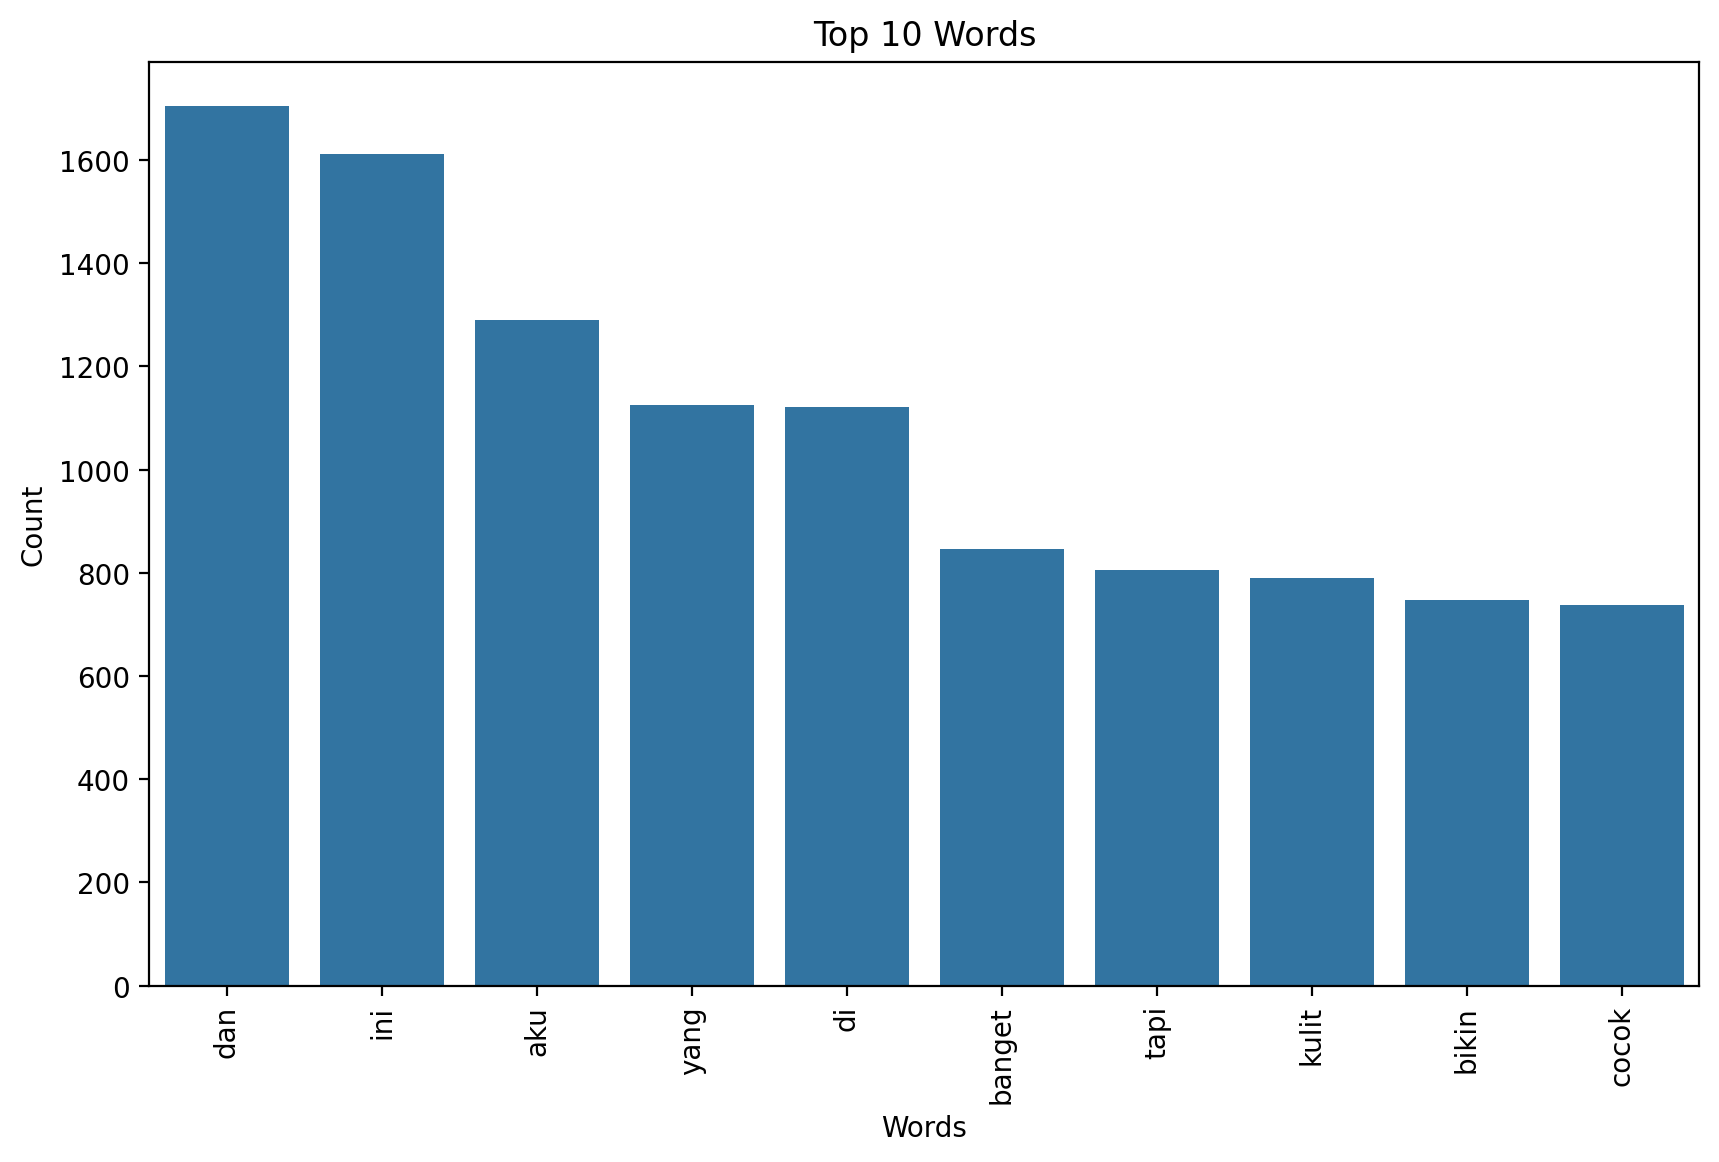

In [ ]:
top_10_words = word_count_df_sort.head(10)
fig, ax = plt.subplots(figsize=(10, 6))
sns.barplot(x='key', y='count', data=top_10_words, ax=ax)
plt.title("Top 10 Words")
plt.xlabel("Words")
plt.ylabel("Count")
plt.xticks(rotation='vertical')
plt.show()

In [ ]:
def merge_again(text):
    return ' '.join(text)

In [ ]:
df['done_reviews'] = df['reviews_tokens_stemmed'].apply(merge_again)

In [ ]:
for i in range(51):
  print(df['done_reviews'].iloc[i])

tahu jenis kulit utama produk kandung hydrating milik kandung sifat tenang kulit pengaruh embel2 serum sifat cerah basic skincare macem2 inti tahu kulit wajah
salah facial wash drugstore layak coba busa kulit tarik pakai jerawat
efek kulit cerah tekstur lembut nyaman asli barang asli
muas harga jangkau kualitas lumayan sedia marketplace
segi packaging oke2 liat warna produk dalem pas dicobain berat warna susah diratain gatau kaya bolong2 garata layering kering crack matte tunggu kering bibir ditempelin bibir overall suka tekstur warna gloss liquid lipstick bagus

salah beli ambil fw pas minimarket cocok kuliktu muncul bruntusan jerawat pipi inget kulit beda beda
asli barang ori
dipake produk bagus banget pasuk ngefek muka sabun muka cinta worth harga segitu cocok produk isi alcohol coba
muka jerawat penasaran coba beruntus stop takut beruntus liat beuaty blogger bagus cocok banget
beli moga cocok
facial wash kulit kering banget huhu kulit minyak jerawat banget worth kulit kering gaterl

In [ ]:
df.head()


,username,rate,date,label,sentimen,reviews,produk,text_length,anomaly_score,reviews_tokens,reviews_tokens_WSW,reviews_normalized,reviews_tokens_stemmed,done_reviews
1945,nadiadiani_,3,19-03-2021 6:58,non,neutral,ketahuilah apa jenis kulitmu dulu utamakan gun...,Acnes Creamy Wash,282,1,"[ketahuilah, apa, jenis, kulitmu, dulu, utamak...","[ketahuilah, jenis, kulitmu, utamakan, produk,...","[ketahuilah, jenis, kulitmu, utamakan, produk,...","[tahu, jenis, kulit, utama, produk, kandung, h...",tahu jenis kulit utama produk kandung hydratin...
2128,jiminee10,3,31-08-2022 5:02,fake,neutral,salah satu facial wash dari drugstore yang lay...,Acnes Creamy Wash,167,1,"[salah, satu, facial, wash, dari, drugstore, y...","[salah, facial, wash, drugstore, layak, dicoba...","[salah, facial, wash, drugstore, layak, dicoba...","[salah, facial, wash, drugstore, layak, coba, ...",salah facial wash drugstore layak coba busa ku...
1050,srihastutik1987,3,2024-05-22 22:24,fake,neutral,efek memberikan kulit tampak lebih cerah tekst...,MS GLOW FACIAL WASH,103,1,"[efek, memberikan, kulit, tampak, lebih, cerah...","[efek, kulit, cerah, tekstur, lembut, nyaman, ...","[efek, kulit, cerah, tekstur, lembut, nyaman, ...","[efek, kulit, cerah, tekstur, lembut, nyaman, ...",efek kulit cerah tekstur lembut nyaman asli ba...
2163,Aisyah_18,3,01-11-2021 11:32,fake,neutral,cukup memuaskan dengan harga yang terjangkau d...,Acnes Creamy Wash,104,1,"[cukup, memuaskan, dengan, harga, yang, terjan...","[memuaskan, harga, terjangkau, kualitas, lumay...","[memuaskan, harga, terjangkau, kualitas, lumay...","[muas, harga, jangkau, kualitas, lumayan, sedi...",muas harga jangkau kualitas lumayan sedia mark...
119,christinjuniarti,3,29-06-2018 1:01,trusted,neutral,dr segi packaging sih oke2 aja dan bisa liat w...,Lip Cream LA Girl,431,1,"[dr, segi, packaging, sih, oke2, aja, dan, bis...","[segi, packaging, oke2, liat, warna, produk, d...","[segi, packaging, oke2, liat, warna, produk, d...","[segi, packaging, oke2, liat, warna, produk, d...",segi packaging oke2 liat warna produk dalem pa...


# Modeling

In [ ]:
import pandas as pd
import numpy as np
import tensorflow as tf
from tensorflow.keras.layers import Embedding, LSTM, Dense, Input, concatenate, Dropout, Bidirectional, Conv1D, MaxPooling1D, GlobalMaxPooling1D
from keras.regularizers import l1, l2
from tensorflow.keras.models import Model
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences
from gensim.models import Word2Vec
from keras.optimizers import Adam


In [ ]:
# Encode labels
label_encoder_review = LabelEncoder()
label_encoder_sentiment = LabelEncoder()
df['label_encoded'] = label_encoder_review.fit_transform(df['label'])
df['sentiment_encoded'] = label_encoder_sentiment.fit_transform(df['sentimen'])

In [ ]:
# Tokenization and Padding
tokenizer = Tokenizer()
tokenizer.fit_on_texts(df['done_reviews'])
sequences = tokenizer.texts_to_sequences(df['done_reviews'])
word_index = tokenizer.word_index

In [ ]:
# Padding sequences
max_sequence_length = 100  # Adjust as needed
data = pad_sequences(sequences, maxlen=max_sequence_length)

In [ ]:
# Prepare embedding matrix with Word2Vec
w2v_model = Word2Vec(sentences=[text.split() for text in df['done_reviews']], vector_size=100, window=5, min_count=1, workers=4)
embedding_matrix = np.zeros((len(word_index) + 1, 100))
for word, i in word_index.items():
    if word in w2v_model.wv:
        embedding_matrix[i] = w2v_model.wv[word]

In [ ]:
# Split the data
X_train, X_test, y_train_label, y_test_label, y_train_sentiment, y_test_sentiment = train_test_split(
    data, df['label_encoded'], df['sentiment_encoded'], test_size=0.2, random_state=42
)

In [ ]:
# Define the model
input_ = Input(shape=(max_sequence_length,))
embedding_layer = Embedding(input_dim=len(word_index) + 1, output_dim=100, input_length=max_sequence_length, trainable=False)
embedding_layer.build((None,))  # Build the embedding layer
embedding_layer.set_weights([embedding_matrix])  # Set the weights of the embedding layer

embedding = embedding_layer(input_)
embedding = Dropout(0.5)(embedding)

In [ ]:
# Convolutional layer
conv = Conv1D(filters=64, kernel_size=5, activation='relu', kernel_regularizer=l2(0.01))(embedding)
conv = MaxPooling1D(pool_size=2)(conv)
conv = Dropout(0.5)(conv)


In [ ]:
# # LSTM layer
# lstm_out = LSTM(128, return_sequences=True, kernel_regularizer=l2(0.01))(embedding)
# lstm_out = Dropout(0.5)(lstm_out)  # Add dropout after first LSTM
# lstm_out = LSTM(64, kernel_regularizer=l2(0.01))(lstm_out)
# lstm_out = Dropout(0.5)(lstm_out)  # Add dropout after second LSTM

In [ ]:
# Bidirectional LSTM layers
lstm_out = Bidirectional(LSTM(128, return_sequences=True, kernel_regularizer=l2(0.01)))(conv)
lstm_out = Dropout(0.5)(lstm_out)  # Add dropout after first Bidirectional LSTM
lstm_out = Bidirectional(LSTM(64, return_sequences=True, kernel_regularizer=l2(0.01)))(lstm_out)
lstm_out = Dropout(0.5)(lstm_out)  # Add dropout after second Bidirectional LSTM
lstm_out = LSTM(32, kernel_regularizer=l2(0.01))(lstm_out)
lstm_out = Dropout(0.5)(lstm_out)  # Add dropout after third LSTM

In [ ]:
# Additional Dense and Dropout layers
dense_out = Dense(128, activation='relu', kernel_regularizer=l2(0.01))(lstm_out)
dense_out = Dropout(0.5)(dense_out)
dense_out = Dense(64, activation='relu', kernel_regularizer=l2(0.01))(dense_out)
dense_out = Dropout(0.5)(dense_out)
dense_out = Dense(32, activation='relu', kernel_regularizer=l2(0.01))(dense_out)
dense_out = Dropout(0.5)(dense_out)

In [ ]:
# Output layers
output_review = Dense(3, activation='softmax', name='review_output', kernel_regularizer=l2(0.01))(dense_out)
output_sentiment = Dense(3, activation='softmax', name='sentiment_output', kernel_regularizer=l2(0.01))(dense_out)


In [ ]:
# Combine into a model
model = Model(inputs=input_, outputs=[output_review, output_sentiment])
# model.compile(optimizer='adam', loss='sparse_categorical_crossentropy', metrics=['accuracy'])
# model.compile(optimizer='adam',
#               loss={'review_output': 'sparse_categorical_crossentropy', 'sentiment_output': 'sparse_categorical_crossentropy'},
#               metrics={'review_output': 'accuracy', 'sentiment_output': 'accuracy'})


In [ ]:
# Summary of the model
model.summary()

Model: "model"
__________________________________________________________________________________________________
 Layer (type)                Output Shape                 Param #   Connected to                  
 input_1 (InputLayer)        [(None, 100)]                0         []                            
                                                                                                  
 embedding (Embedding)       (None, 100, 100)             309600    ['input_1[0][0]']             
                                                                                                  
 dropout (Dropout)           (None, 100, 100)             0         ['embedding[0][0]']           
                                                                                                  
 conv1d (Conv1D)             (None, 96, 64)               32064     ['dropout[0][0]']             
                                                                                              

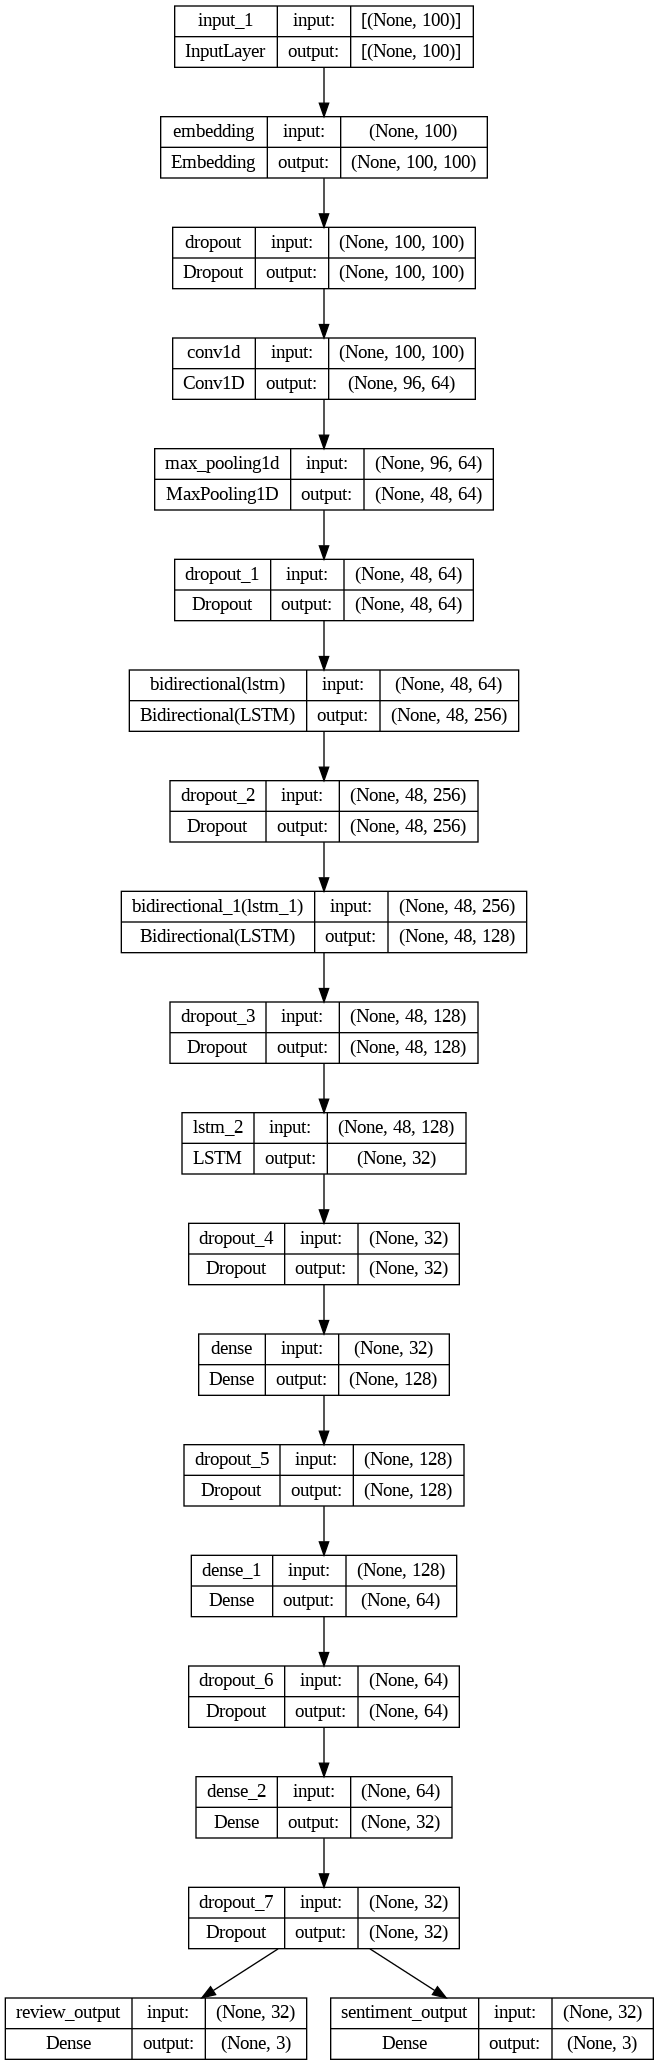

In [ ]:
from keras.utils import plot_model

# Visualize the model and save it to file
plot_model(model, to_file='model_plot.png', show_shapes=True, show_layer_names=True)

In [ ]:
# Compile the model with metrics for each output
optimizer = Adam(learning_rate=0.001)
model.compile(optimizer='adam',
              loss={'review_output': 'sparse_categorical_crossentropy', 'sentiment_output': 'sparse_categorical_crossentropy'},
              metrics={'review_output': 'accuracy', 'sentiment_output': 'accuracy'})

In [ ]:
from keras.callbacks import EarlyStopping, ModelCheckpoint

# Define Early Stopping and Model Checkpoint callbacks
early_stopping = EarlyStopping(
    monitor='val_loss',
    patience=3,
    restore_best_weights=True
)

model_checkpoint = ModelCheckpoint(
    'best_model.keras',
    monitor='val_loss',
    save_best_only=True,
    mode='min'
)

In [ ]:
# Train the model with callbacks
history = model.fit(
    X_train,
    {'review_output': y_train_label, 'sentiment_output': y_train_sentiment},
    epochs=36,
    batch_size=32,
    validation_split=0.2,
    callbacks=[early_stopping, model_checkpoint]
    # callbacks=[model_checkpoint]
)

Epoch 1/36
48/48 [==============================] - 15s 315ms/step - loss: 1.9800 - review_output_loss: 0.7768 - sentiment_output_loss: 1.0987 - review_output_accuracy: 0.6380 - sentiment_output_accuracy: 0.3672 - val_loss: 1.9863 - val_review_output_loss: 0.7790 - val_sentiment_output_loss: 1.1016 - val_review_output_accuracy: 0.5807 - val_sentiment_output_accuracy: 0.3516
Epoch 2/36
48/48 [==============================] - 15s 304ms/step - loss: 1.9766 - review_output_loss: 0.7699 - sentiment_output_loss: 1.1001 - review_output_accuracy: 0.6406 - sentiment_output_accuracy: 0.3444 - val_loss: 2.0147 - val_review_output_loss: 0.8082 - val_sentiment_output_loss: 1.0998 - val_review_output_accuracy: 0.5885 - val_sentiment_output_accuracy: 0.3385
Epoch 3/36
48/48 [==============================] - 15s 313ms/step - loss: 1.9778 - review_output_loss: 0.7766 - sentiment_output_loss: 1.0993 - review_output_accuracy: 0.6432 - sentiment_output_accuracy: 0.3385 - val_loss: 1.9724 - val_review_ou

In [ ]:
# Evaluate the model
results = model.evaluate(X_test, {'review_output': y_test_label, 'sentiment_output': y_test_sentiment})
print(f'Test results - Loss: {results[0]} - Review Output Loss: {results[1]} - Sentiment Output Loss: {results[2]}')

15/15 [==============================] - 1s 81ms/step - loss: 1.9107 - review_output_loss: 0.7257 - sentiment_output_loss: 1.0963 - review_output_accuracy: 0.6375 - sentiment_output_accuracy: 0.3854
Test results - Loss: 1.9106998443603516 - Review Output Loss: 0.7256631255149841 - Sentiment Output Loss: 1.0962574481964111


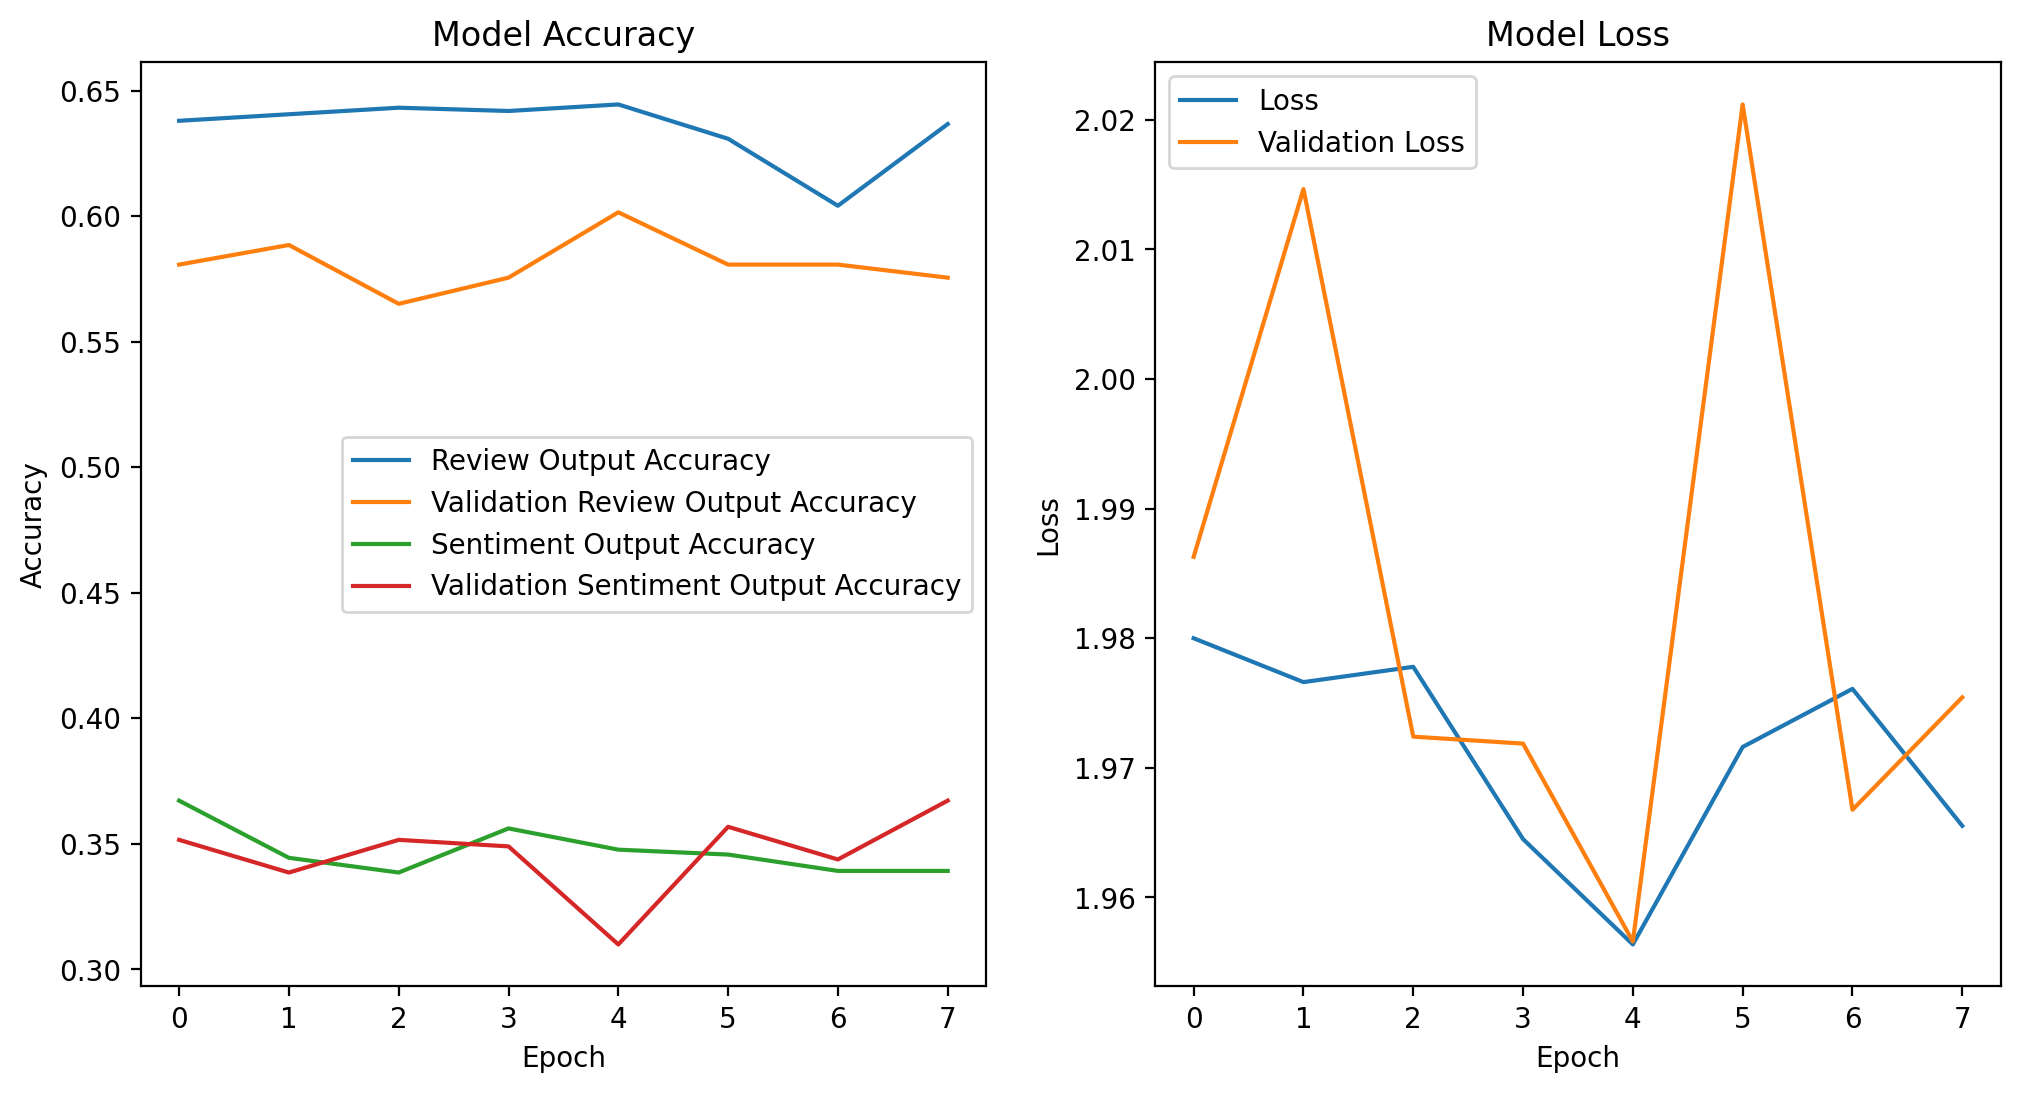

In [ ]:
import matplotlib.pyplot as plt

# Plot learning curve
def plot_learning_curve(history):
    plt.figure(figsize=(12, 6))

    # Plot accuracy
    plt.subplot(1, 2, 1)
    plt.plot(history.history['review_output_accuracy'], label='Review Output Accuracy')
    plt.plot(history.history['val_review_output_accuracy'], label='Validation Review Output Accuracy')
    plt.plot(history.history['sentiment_output_accuracy'], label='Sentiment Output Accuracy')
    plt.plot(history.history['val_sentiment_output_accuracy'], label='Validation Sentiment Output Accuracy')
    plt.title('Model Accuracy')
    plt.xlabel('Epoch')
    plt.ylabel('Accuracy')
    plt.legend()

    # Plot loss
    plt.subplot(1, 2, 2)
    plt.plot(history.history['loss'], label='Loss')
    plt.plot(history.history['val_loss'], label='Validation Loss')
    plt.title('Model Loss')
    plt.xlabel('Epoch')
    plt.ylabel('Loss')
    plt.legend()

    plt.show()

# Plot learning curve
plot_learning_curve(history)


In [ ]:

from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay, classification_report, accuracy_score
from sklearn.preprocessing import LabelEncoder

# Predict on the test set
y_test_pred_review = np.argmax(model.predict(X_test)[0], axis=1)
y_test_pred_sentiment = np.argmax(model.predict(X_test)[1], axis=1)

# Convert labels back to original encoding
y_test_true_review = y_test_label
y_test_true_sentiment = y_test_sentiment

15/15 [==============================] - 1s 83ms/step


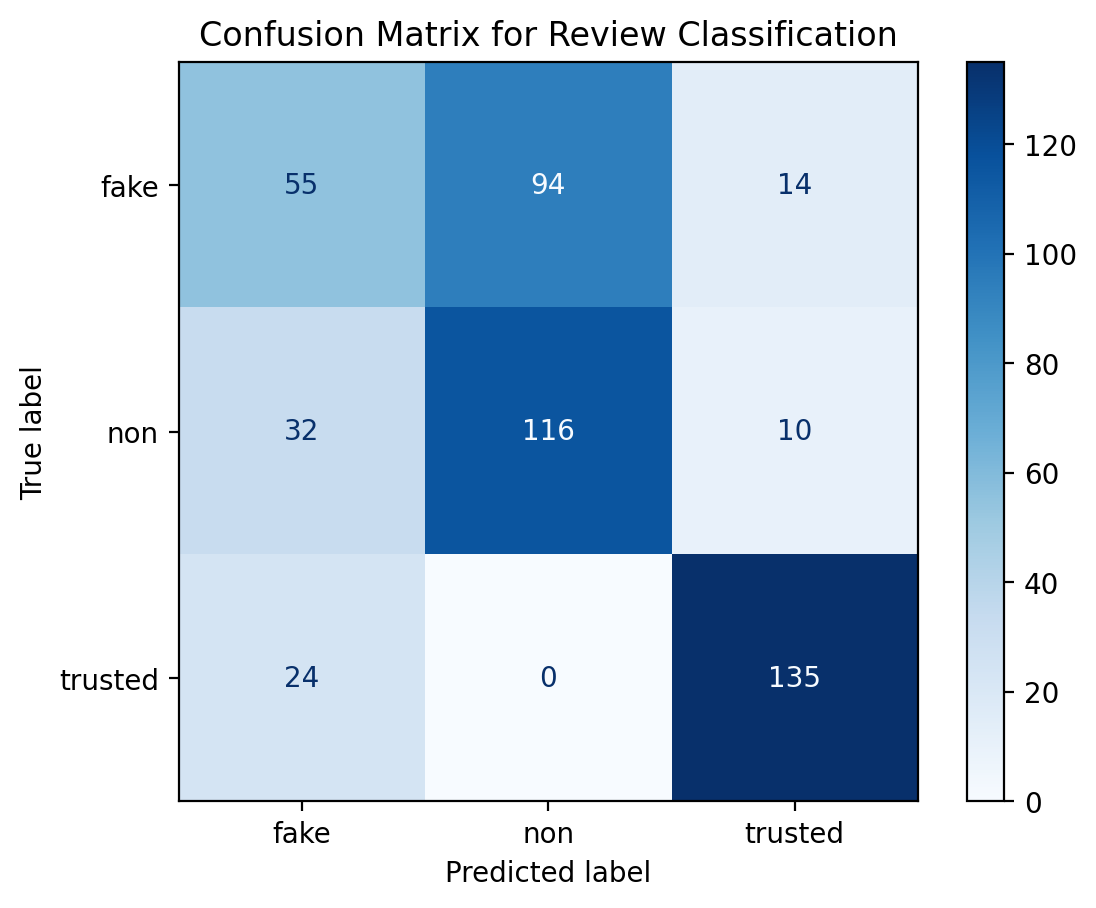

In [ ]:
# Plot confusion matrix for review prediction
cm_review = confusion_matrix(y_test_true_review, y_test_pred_review)
disp_review = ConfusionMatrixDisplay(confusion_matrix=cm_review, display_labels=label_encoder_review.classes_)
disp_review.plot(cmap=plt.cm.Blues)
plt.title('Confusion Matrix for Review Classification')
plt.show()

In [ ]:
print(classification_report(y_test_true_review, y_test_pred_review, digits = 4))

print("Accuracy score: ", accuracy_score(y_test_true_review, y_test_pred_review) * 100, '%')

              precision    recall  f1-score   support

           0     0.4955    0.3374    0.4015       163
           1     0.5524    0.7342    0.6304       158
           2     0.8491    0.8491    0.8491       159

    accuracy                         0.6375       480
   macro avg     0.6323    0.6402    0.6270       480
weighted avg     0.6313    0.6375    0.6251       480

Accuracy score:  63.74999999999999 %


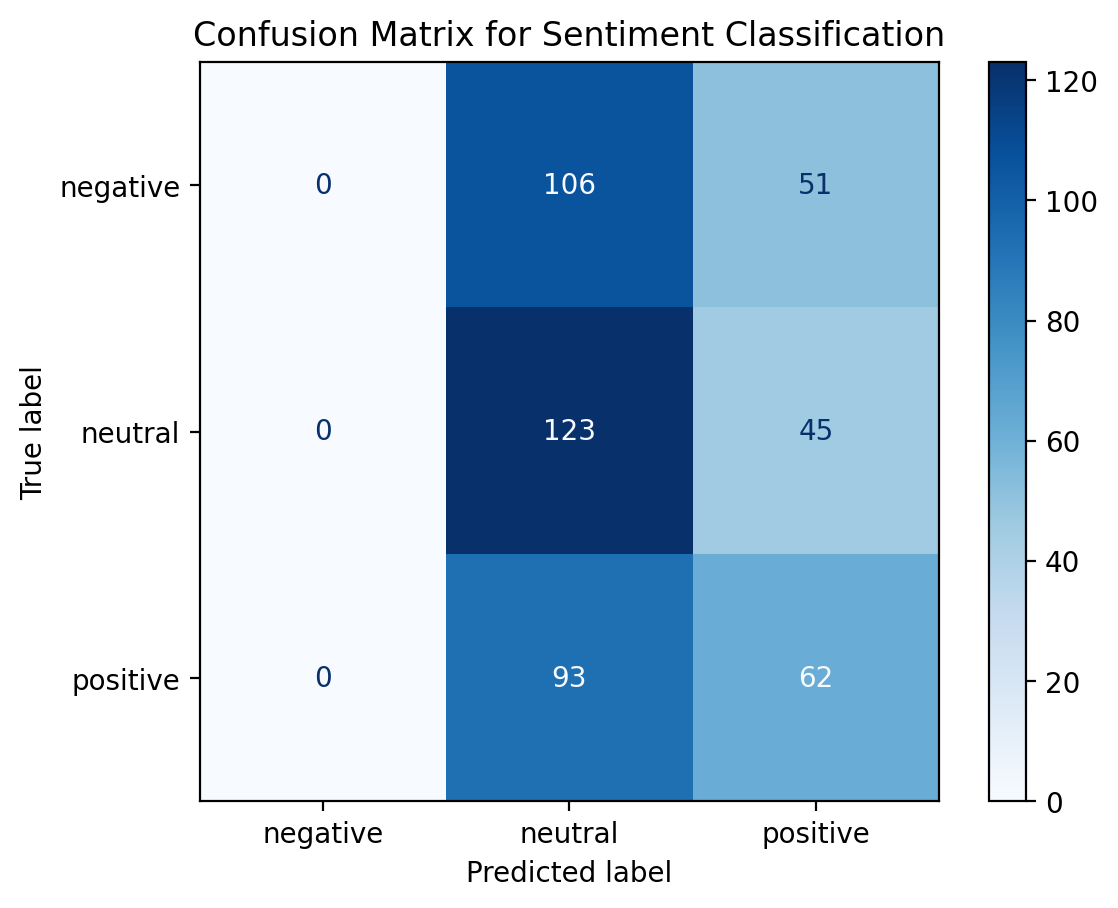

In [ ]:
# Plot confusion matrix for sentiment prediction
cm_sentiment = confusion_matrix(y_test_true_sentiment, y_test_pred_sentiment)
disp_sentiment = ConfusionMatrixDisplay(confusion_matrix=cm_sentiment, display_labels=label_encoder_sentiment.classes_)
disp_sentiment.plot(cmap=plt.cm.Blues)
plt.title('Confusion Matrix for Sentiment Classification')
plt.show()

In [ ]:
print(classification_report(y_test_true_sentiment, y_test_pred_sentiment, digits = 4))

print("Accuracy score: ", accuracy_score(y_test_true_sentiment, y_test_pred_sentiment) * 100, '%')

              precision    recall  f1-score   support

           0     0.0000    0.0000    0.0000       157
           1     0.3820    0.7321    0.5020       168
           2     0.3924    0.4000    0.3962       155

    accuracy                         0.3854       480
   macro avg     0.2581    0.3774    0.2994       480
weighted avg     0.2604    0.3854    0.3036       480

Accuracy score:  38.54166666666667 %


In [ ]:
# Function for prediction with percentage
def predict_review_with_percentage(model, tokenizer, review_text):
    sequence = tokenizer.texts_to_sequences([review_text])
    padded_sequence = pad_sequences(sequence, maxlen=max_sequence_length)
    prediction = model.predict(padded_sequence)

    review_pred = label_encoder_review.inverse_transform(np.argmax(prediction[0], axis=1))[0]
    sentiment_pred = label_encoder_sentiment.inverse_transform(np.argmax(prediction[1], axis=1))[0]

    # Calculate percentage
    review_percentage = np.max(prediction[0]) * 100
    sentiment_percentage = np.max(prediction[1]) * 100

    return review_pred, review_percentage, sentiment_pred, sentiment_percentage



# Function to predict star rating based on sentiment percentage
def predict_star_rating(sentiment_percentage):
    if sentiment_percentage <= 20:
        return 1
    elif sentiment_percentage <= 40:
        return 2
    elif sentiment_percentage <= 60:
        return 3
    elif sentiment_percentage <= 80:
        return 4
    else:
        return 5




In [ ]:
# Example usage by user input
user_review = input("Masukkan review produk: ")
review_pred, review_percentage, sentiment_pred, sentiment_percentage = predict_review_with_percentage(model, tokenizer, user_review)

# Predict star rating based on sentiment percentage
star_rating = predict_star_rating(sentiment_percentage)
print(' ________________  Review Analysis Result ______________')
print(f'| Review : {review_pred} - Percentage: {review_percentage:.2f}%','                    |')
print(f'| Sentiment : {sentiment_pred} - Percentage: {sentiment_percentage:.2f}%','            |')
print(f'| Star Rating: {star_rating}','                                       |')
print(' -------------------------------------------------------')

Masukkan review produk: apakah saya bisa minjem duit?
1/1 [==============================] - 2s 2s/step
 ________________  Review Analysis Result ______________
| Review : non - Percentage: 57.69%                     |
| Sentiment : neutral - Percentage: 35.13%             |
| Star Rating: 2                                        |
 -------------------------------------------------------
